In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import brutefit as bf
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import scipy.optimize as opt
import matplotlib.pyplot as plt
import cbsyst as cb
from b_funks.helpers import isolate_constant_conditions
from b_funks.previous_models import fit_data_with_previous_models

import uncertainties as un
import uncertainties.unumpy as unp
nom = unp.nominal_values
err = unp.std_devs

In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import brutefit as bf
from sklearn.preprocessing import StandardScaler

from uncertainties import unumpy as unp
from b_funks import load

nom = unp.nominal_values
err = unp.std_devs

plt.rcParams['figure.dpi'] = 150

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
odat = load.b_data(None)
dat = load.b_data()

In [4]:
# odat = pd.read_csv('data/B_compiled.csv', index_col=0, header=[0,1])

# # package uncertainties
# odat.loc[:, ('Measured', 'B/Caf')] = unp.uarray(odat.loc[:, ('Measured', 'B/Caf')], odat.loc[:, ('Uncertainties', 'se')])

# odat.loc[:, ('Measured', 'KB')] = odat.loc[:, ('Measured', 'B/Caf')] / (odat.loc[:, ('Measured', '[B]sw')] / odat.loc[:, ('csys_mid', 'DIC')])
# odat.loc[:, ('Measured', 'KB_HCO3')] = odat.loc[:, ('Measured', 'B/Caf')] / (odat.loc[:, ('Measured', '[B]sw')] / odat.loc[:, ('csys_mid', 'HCO3')])

# # normalise B/Ca to ambient [B] - this is a linear correction, see Allen et al (2011) Fig 2
# # B_ambient = 416.
# # odat.loc[:, ('Measured', 'B/Caf_corr')] = odat.loc[:, ('Measured', 'B/Caf')] * B_ambient / odat.loc[:, ('Measured', '[B]sw')]
# # odat.loc[:, ('Measured', 'KB_corr')] = odat.loc[:, ('Measured', 'B/Caf_corr')] / (B_ambient / odat.loc[:, ('csys_mid', 'DIC')])
# # re-calculated carbon system to ambient [B]

# # for c in odat.csys_mid.columns:
# #     odat.loc[:, ('csys_mid_corr', c)] = odat.loc[:, ('csys_mid', c)]
# # odat.loc[:, ('csys_mid_corr', 'f_BT')] = B_ambient / odat[('csys_mid', 'BT')]
# # odat.loc[:, ('csys_mid_corr', 'TA')] = odat[('csys_mid', 'TA')] - odat[('csys_mid', 'BO4')] + odat[('csys_mid', 'BO4')] * odat[('csys_mid_corr', 'f_BT')]

# # for c in ['BT', 'BO3', 'BO4']:
# #     odat.loc[:, ('csys_mid_corr', c)] *= odat.loc[:, ('csys_mid_corr', 'f_BT')]

# # a few derived parameters
# odat[('csys_mid', 'del_CO3')] = 1e6 * odat[('csys_mid', 'KspC')] / (1e-3 * odat[('Measured', '[Ca]sw')])
# # odat[('csys_mid_corr', 'del_CO3')] = 1e6 * odat[('csys_mid_corr', 'KspC')] / (1e-3 * odat[('Measured', '[Ca]sw')])

# odat[('csys_mid', 'BT_DIC')] = odat[('csys_mid', 'BT')] / odat[('csys_mid', 'DIC')]
# # odat[('csys_mid_corr', 'BT_DIC')] = odat[('csys_mid_corr', 'BT')] / odat[('csys_mid_corr', 'DIC')]

# # comment out studies here to remove them
# mdict = {
#     'This Study': 'o', 
#     'Haynes et al. (2017)': 's', 
#     'Allen et al. (2011)': 'd',
#     'Howes et al. (2017)': '*'
# }

# kdat = odat.loc[odat.loc[:, ('Measured', 'who')].isin(['This Study'])]
# dat = odat.loc[odat.loc[:, ('Measured', 'who')].isin(mdict)]

## Pairs of Parameters for KB denominator:
 - B, DIC
 - B, HCO3
 - B, CO3
 - BO4, DIC
 - BO4, HCO3
 - BO4, CO3
 
Extra parameters:
<!--  - Sal -->
<!--  - Temp -->
 - Ca
 - Mg
 - Omega
 - CO3
 - DIC
 - pH

## Fitting B/Ca

This is innapropriate because the objective function is:

$$
y = f(\dots) + m R
$$
where R is the solution ratio of interest.

To convert this to KB:
$$
K_B = \frac{y}{R} = \frac{f(\dots)}{R} + m
$$
Which is not a sensible functional form.

In [4]:
extras = [
    ('Measured', '[Ca]sw'),
    ('Measured', '[Mg]sw'),
    ('csys_mid', 'Omega'),
    ('csys_mid', 'CO3'),
    ('csys_mid', 'DIC'),
    ('csys_mid', 'pHtot')
]

brutes = {}

y = nom(dat.loc[:, ('Measured', 'B/Caf')])
w = 1 / err(dat.loc[:, ('Measured', 'B/Caf')])**2

for b in ['BT', 'BO4']:
    for c in ['DIC', 'HCO3', 'CO3']:
        ratio = f'{b}_{c}'
        print(ratio)
        candidates = dat.loc[:, extras]
        candidates.loc[:, ('deriv', ratio)] = dat.loc[:, ('csys_mid', b)] / dat.loc[:, ('csys_mid', c)]
        brutes[ratio] = bf.Brute(X=candidates.values, y=y, w=w, varnames=[c[1] for c in candidates.columns], max_interaction_order=0, Scaler=StandardScaler)
        _ = brutes[ratio].evaluate_polynomials()

BT_DIC


Evaluating Models::   0%|          | 0/128 [00:00<?, ?it/s]

BT_HCO3


Evaluating Models::   0%|          | 0/128 [00:00<?, ?it/s]

BT_CO3


Evaluating Models::   0%|          | 0/128 [00:00<?, ?it/s]

BO4_DIC


Evaluating Models::   0%|          | 0/128 [00:00<?, ?it/s]

BO4_HCO3


Evaluating Models::   0%|          | 0/128 [00:00<?, ?it/s]

BO4_CO3


Evaluating Models::   0%|          | 0/128 [00:00<?, ?it/s]

In [5]:
# aggregate fits
df = []
for r, b in brutes.items():
    tdf = b.modelfits
    tdf['r'] = r
    df.append(tdf)
         
df = pd.concat(df)

# calculate global metrics
df.loc[:, ('metrics', 'BF_max')] = df.loc[:, ('metrics', 'BF0')] / df.loc[:, ('metrics', 'BF0')].max()
df.loc[:, ('metrics', 'K')] = 1 / df.loc[:, ('metrics', 'BF_max')]
df.loc[:, ('metrics', 'evidence_against')] = None

df.sort_values(('metrics', 'K'), inplace=True)
df.reset_index(drop=True, inplace=True)

In [6]:
df.head()

coefs                                                              \
          C X0^1 X1^1      X2^1      X3^1      X4^1      X5^1      X6^1   
0 -0.175062  NaN  NaN       NaN  0.071107       NaN       NaN  0.923409   
1 -0.138923  NaN  NaN       NaN  0.057178  0.146826       NaN  0.939798   
2 -0.147128  NaN  NaN       NaN       NaN  0.169347       NaN  0.942992   
3 -0.154041  NaN  NaN       NaN  0.192009       NaN -0.106899  0.936258   
4 -0.137588  NaN  NaN  0.039904       NaN  0.159075       NaN  0.947900   

   p_values       ...                                     metrics  \
          C X0^1  ...      X4^1      X5^1          X6^1        R2   
0  0.030034  NaN  ...       NaN       NaN  3.812506e-13  0.821687   
1  0.070129  NaN  ...  0.131733       NaN  5.340173e-12  0.840578   
2  0.070352  NaN  ...  0.080796       NaN  2.054001e-11  0.814714   
3  0.048656  NaN  ...       NaN  0.402525  3.413714e-11  0.836222   
4  0.077761  NaN  ...  0.093442       NaN  6.783019e-12  0.834688   

                                                                         r  
            BF0 n_covariates    BF_max         K evidence_against           
0  1.208972e+09          2.0  1.000000  1.000000             None  BT_HCO3  
1  7.828174e+08          3.0  0.647507  1.544386             None  BT_HCO3  
2  7.015990e+08          2.0  0.580327  1.723166             None  BT_HCO3  
3  5.419508e+08          3.0  0.448274  2.230778             None  BT_HCO3  
4  4.772952e+08          3.0  0.394794  2.532965             None  BT_HCO3  

[5 rows x 23 columns]

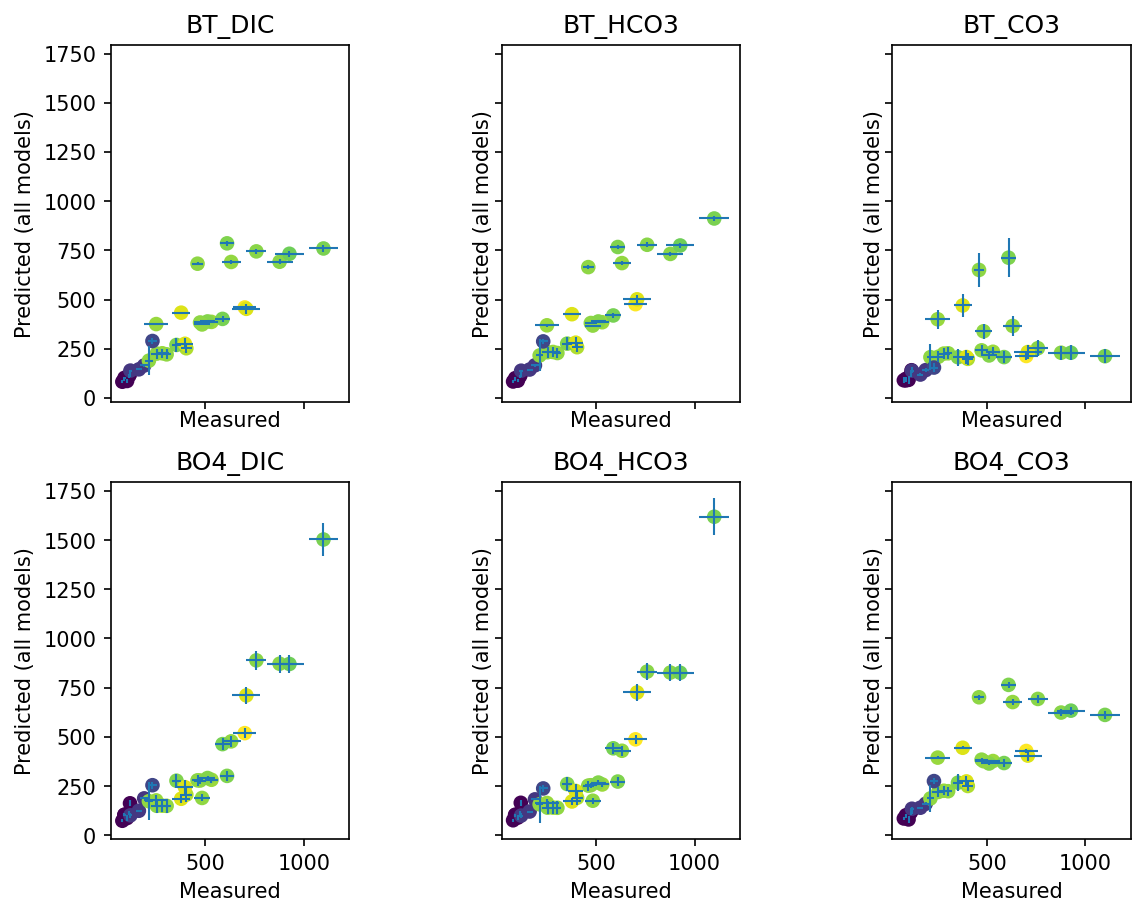

In [7]:
fig, axs = plt.subplots(2, 3, figsize=[8, 6], sharex=True, sharey=True, constrained_layout=True)

for k, ax in zip(brutes.keys(), axs.flat):
    brutes[k].plot_obs_vs_pred(ax=ax, c=dat[('Measured', '[B]sw')])
    ax.set_title(k)

The main driver of all patterns is $[B]_{SW}$ - must fit KB. It's not surprising we can't fit B/Ca well including a solution ratio, beause the objective function is daft. 

## Fitting KB (B/DIC)

This is more useful, with the objective function:
$$
K_B = \frac{y}{R} = f(\dots)
$$
which converts to B/Ca:
$$
y = R~f(\dots)
$$

In [8]:
extras = [
    ('Measured', '[Ca]sw'),
    ('Measured', '[Mg]sw'),
#     ('Measured', 'Temp'),
#     ('csys_mid', 'Omega'),
    ('csys_mid', 'BO4'),
    ('csys_mid', 'BT'),
    ('csys_mid', 'CO3'),
    ('csys_mid', 'pHtot'),
    ('csys_mid', 'DIC'),
#     ('csys_mid', 'del_CO3'),
]

y = nom(dat.loc[:, ('Measured', 'KB')])
w = 1 / err(dat.loc[:, ('Measured', 'KB')])**2
# y = dat.loc[:, ('Measured', 'B/Caf')] / (dat.loc[:, ('csys_mid', 'BT')] / dat.loc[:, ('csys_mid', 'HCO3')])

candidates = dat.loc[:, extras]
kbrutes = bf.Brute(X=candidates.values, y=y, varnames=[c[1] for c in candidates.columns], w=w, max_interaction_order=0, Scaler=StandardScaler)
df = kbrutes.evaluate_polynomials()

Evaluating Models::   0%|          | 0/128 [00:00<?, ?it/s]

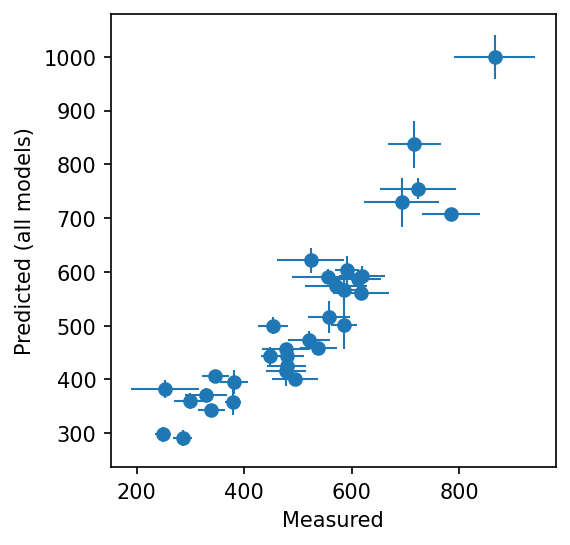

In [9]:
kbrutes.plot_obs_vs_pred()

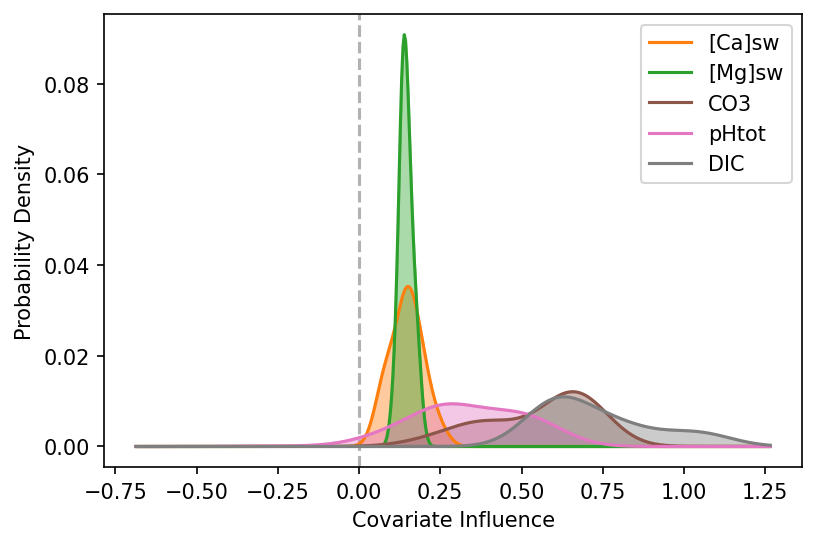

In [10]:
kbrutes.plot_param_dists(filter_zeros=0.05)
plt.legend()

Text(0.05, 0.95, 'R2: 0.960')

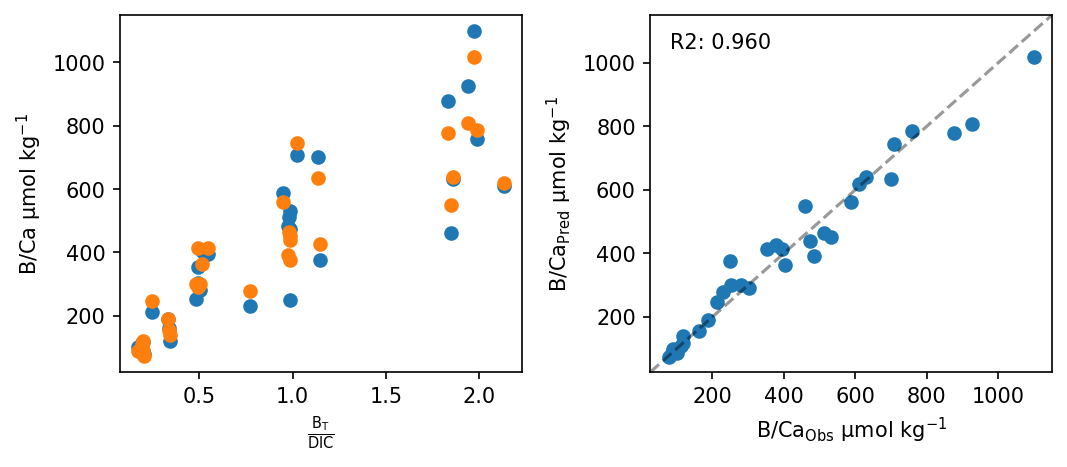

In [11]:
# How well can this predicted KB reproduce B/Ca?
pred_BCa = kbrutes.pred_means * (dat.csys_mid.BT / dat.csys_mid.DIC)

fig, axs = plt.subplots(1, 2, figsize=[7,3], constrained_layout=True)

ax = axs[0]
ax.scatter(dat.csys_mid.BT / dat.csys_mid.DIC, nom(dat.loc[:, ('Measured', 'B/Caf')]), label='Measured')
ax.scatter(dat.csys_mid.BT / dat.csys_mid.DIC, pred_BCa, label='Predicted')
ax.set_xlabel(r'$\frac{B_T}{DIC}$')
ax.set_ylabel(r'B/Ca $\mu mol~kg^{-1}$')

ax = axs[1]
ax.scatter(nom(dat.loc[:, ('Measured', 'B/Caf')]), pred_BCa)
ax.set_xlabel(r'$B/Ca_{Obs} ~\mu mol~kg^{-1}$')
ax.set_ylabel(r'$B/Ca_{Pred} ~\mu mol~kg^{-1}$')

lim = ax.get_xlim()
ax.set_xlim(*lim)
ax.set_ylim(*lim)
ax.plot(lim, lim, ls='dashed', color=(0,0,0,0.4))

r2 = bf.stats.calc_R2(nom(dat.loc[:, ('Measured', 'B/Caf')]), pred_BCa)
ax.text(0.05, 0.95, f'R2: {r2:.3f}', va='top', ha='left', transform=ax.transAxes)

In [12]:
# pd.plotting.scatter_matrix(dat.loc[:, extras], figsize=[16,16], diagonal='kde');

In [13]:
kbrutes.varnames

['[Ca]sw', '[Mg]sw', 'BO4', 'BT', 'CO3', 'pHtot', 'DIC']

In [14]:
df.head(10)

coefs                                                              \
          C      X0^1      X1^1      X2^1      X3^1      X4^1      X5^1   
0  0.041889       NaN  0.135096       NaN       NaN  0.667455       NaN   
1  0.006510       NaN       NaN       NaN       NaN  0.656246       NaN   
2  0.052063       NaN  0.157574       NaN       NaN  0.372275  0.245877   
3  0.003097  0.137974       NaN       NaN       NaN  0.695960       NaN   
4  0.000202       NaN  0.146399       NaN -0.071780  0.665619       NaN   
5  0.033584  0.087118  0.111612       NaN       NaN  0.690583       NaN   
6  0.028468       NaN  0.146560  0.350209 -0.235405  0.445598       NaN   
7  0.008498       NaN  0.170177       NaN -0.075562  0.361086  0.253587   
8  0.049623       NaN  0.179534       NaN       NaN       NaN  0.502713   
9  0.008124       NaN       NaN       NaN       NaN  0.544385  0.092593   

             p_values            ...                                    \
       X6^1         C      X0^1  ...      X3^1          X4^1      X5^1   
0  0.597479  0.601244       NaN  ...       NaN  9.674461e-09       NaN   
1  0.613766  0.938944       NaN  ...       NaN  4.302583e-08       NaN   
2  0.794788  0.505592       NaN  ...       NaN  5.488463e-02  0.184607   
3  0.606071  0.970166  0.107463  ...       NaN  8.729978e-09       NaN   
4  0.569292  0.997965       NaN  ...  0.375904  8.482747e-09       NaN   
5  0.595452  0.674723  0.315988  ...       NaN  5.030435e-09       NaN   
6  0.730236  0.709492       NaN  ...  0.068857  5.057753e-03       NaN   
7  0.771303  0.911541       NaN  ...  0.335886  5.763383e-02  0.164066   
8  1.042145  0.557828       NaN  ...       NaN           NaN  0.000003   
9  0.689089  0.924100       NaN  ...       NaN  1.052455e-02  0.631027   

                  metrics                                                 \
           X6^1        R2           BF0 n_covariates    BF_max         K   
0  8.864972e-08  0.817368  1.230169e+08          3.0  1.000000  1.000000   
1  1.586024e-07  0.786706  9.570384e+07          2.0  0.777973  1.285392   
2  4.056863e-06  0.832583  6.534921e+07          4.0  0.531221  1.882454   
3  1.271814e-07  0.804252  4.801445e+07          3.0  0.390308  2.562081   
4  2.163572e-07  0.827559  4.446431e+07          4.0  0.361449  2.766644   
5  1.013732e-07  0.823962  3.398878e+07          4.0  0.276294  3.619339   
6  1.973448e-06  0.845122  3.234903e+07          5.0  0.262964  3.802800   
7  5.321366e-06  0.844488  3.073890e+07          5.0  0.249875  4.001994   
8  2.418066e-13  0.796426  2.824207e+07          3.0  0.229579  4.355803   
9  9.445091e-05  0.792418  2.169854e+07          3.0  0.176387  5.669364   

                                       
                     evidence_against  
0                          Best Model  
1  Not worth more than a bare mention  
2  Not worth more than a bare mention  
3  Not worth more than a bare mention  
4  Not worth more than a bare mention  
5         Substantially less probably  
6         Substantially less probably  
7         Substantially less probably  
8         Substantially less probably  
9         Substantially less probably  

[10 rows x 22 columns]

## Fitting KB (denominator agnosticator)

In [15]:
dat.Measured.who.unique()

array(['This Study'], dtype=object)

In [16]:
# dat = odat
# dat = odat.loc[~odat.Measured.who.isin(['Kaczmarek et al. (2015)'])]
dat = odat.loc[~odat.Measured.who.isin(['Kaczmarek et al. (2015)', 'Howes et al. (2017)'])]
# dat = odat.loc[~odat.Measured.who.isin(['Howes et al. (2017)'])]
# dat = odat.loc[odat.Measured.who.isin(['Kaczmarek et al. (2015)', 'Howes et al. (2017)'])]
# dat = dat.loc[odat.Measured.Species == 'universa']

In [17]:
denominators = {}
KBs = {}
y = dat.loc[:, ('Measured', 'B/Caf')]
for b in ['BT', 'BO4']:
    for c in ['DIC', 'HCO3', 'CO3']:
        ratio = f'{b}_{c}'
        denominators[ratio] = (dat.loc[:, ('csys_mid', b)] / dat.loc[:, ('csys_mid', c)])
        KBs[ratio] = y / denominators[ratio]

ratio = 'BO4_sqrt(CO3)'
denominators[ratio] = (dat.loc[:, ('csys_mid', 'BO4')] / dat.loc[:, ('csys_mid', 'CO3')]**0.5)
KBs[ratio] = y / denominators[ratio]

# Andy logic
ratio = 'BO4_(CO3*sqrt(Ca))'
denominators[ratio] = (dat.loc[:, ('csys_mid', 'BO4')] / (dat.loc[:, ('csys_mid', 'CO3')] * dat.loc[:, ('Measured', '[Ca]sw')]**0.5))
KBs[ratio] = y / denominators[ratio]

ratio = 'BO4_(HCO3*sqrt(Ca))'
denominators[ratio] = (dat.loc[:, ('csys_mid', 'BO4')] / (dat.loc[:, ('csys_mid', 'HCO3')] * dat.loc[:, ('Measured', '[Ca]sw')]**0.5))
KBs[ratio] = y / denominators[ratio]

denominators['sal'] = dat.loc[:, ('Measured', 'Salinity')]

In [18]:
# # relationships between denominators
# import seaborn as sns
# sns.pairplot(pd.DataFrame.from_dict(denominators), height=1)

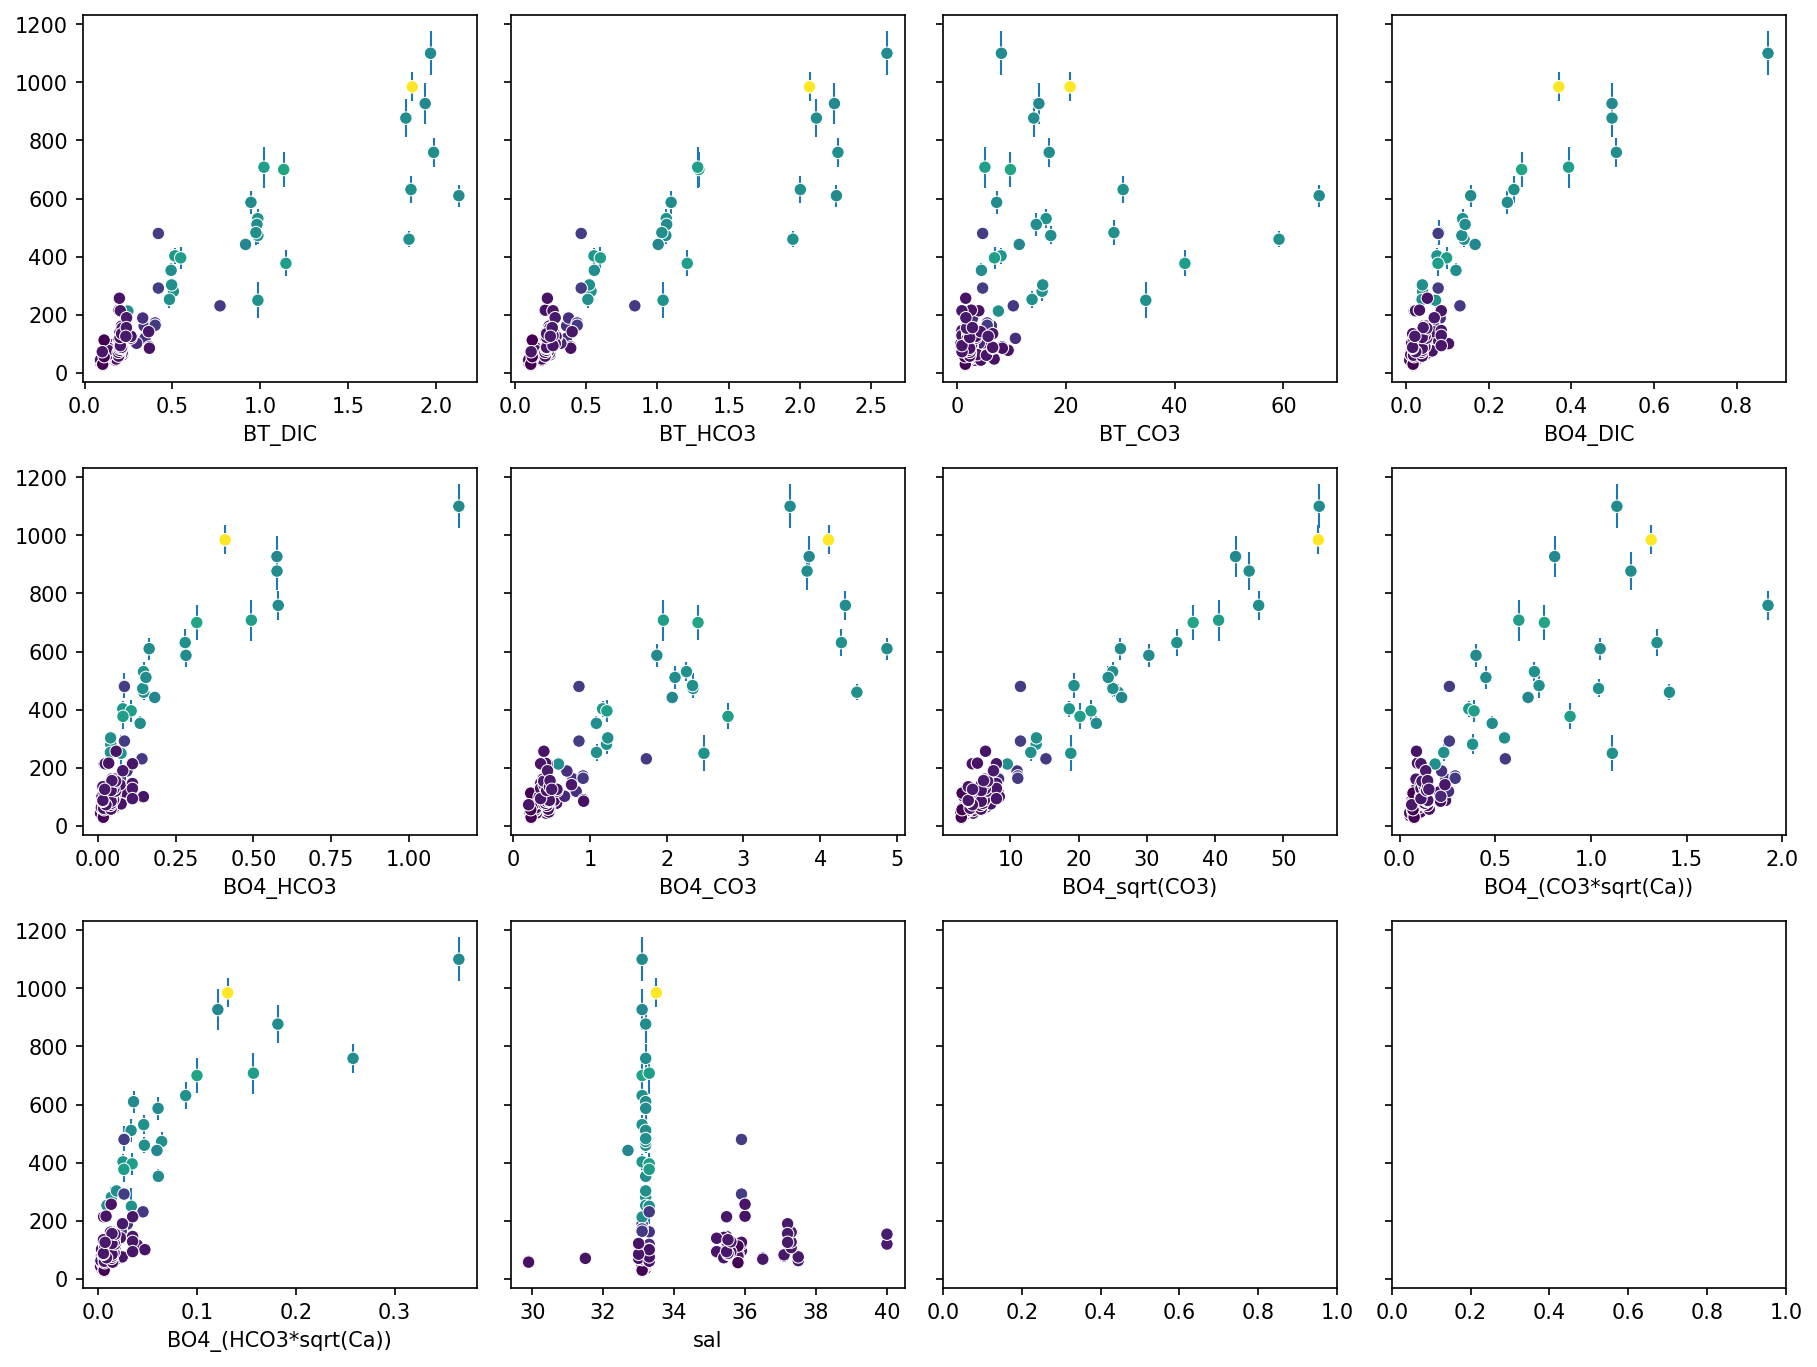

In [19]:
fig, axs = plt.subplots(3, 4, figsize=[12, 9], constrained_layout=True, sharey=True)

y = nom(dat.loc[:, ('Measured', 'B/Caf')])
y_err = err(dat.loc[:, ('Measured', 'B/Caf')])

for k, ax in zip(denominators.keys(), axs.flat):
    ax.scatter(denominators[k], y, lw=0.5, edgecolor='w', c=dat.csys_mid.BT)
    ax.errorbar(denominators[k], y, y_err, zorder=-1, lw=0, elinewidth=1)
    ax.set_xlabel(k)

In [20]:
sw = cb.CBsys(TA=2300, pHtot=np.array([7.5, 8.5]))
sw.BO4 / np.sqrt(sw.CO3)

array([3.61003473, 8.94761906])

In [21]:
dat.Measured.who.unique()

array(['This Study', 'Haynes et al. (2017)', 'Haynes et al. (2019)',
       'Allen et al. (2011)', 'Allen et al. (2012)',
       'Henehan et al. (2015)'], dtype=object)

In [22]:
dat.csys_mid

DIC      TA         CO3         HCO3        CO2     pHtot  \
0    1926.776824  1942.0   42.305990  1832.431639  52.039195  7.438282   
1    2015.871987  2198.0  126.424277  1873.848789  15.598921  7.960929   
2    2000.395743  2470.0  318.529784  1676.935373   4.930586  8.412801   
3    2275.939988  2336.0   85.380852  2134.522162  56.036974  7.441877   
4    2050.156083  2309.0  198.059581  1835.813379  16.283123  7.913947   
..           ...     ...         ...          ...        ...       ...   
118  2006.598744  2061.0   64.809496  1898.789057  43.000191  7.487305   
119  2074.904832  2755.0  490.626220  1580.348462   3.930150  8.446886   
120  1850.757675  2258.0  279.100004  1564.534732   7.122939  8.176011   
121  1858.461943  2083.0  157.910334  1685.932540  14.619069  7.896207   
122  1885.530476  1972.0   77.783834  1774.854874  32.891768  7.566363   

            BO4         BO3     BT          KspC             H      Omega  \
0     23.992402  372.007598  396.0  3.690644e-07  3.645168e-08   2.187148   
1     67.715002  328.284998  396.0  3.328542e-07  1.094134e-08   1.887699   
2    145.844690  250.155310  396.0  3.321720e-07  3.865443e-09   4.708348   
3     28.929330  367.070670  396.0  5.407766e-07  3.615119e-08   3.115083   
4     72.151799  323.848201  396.0  4.922679e-07  1.219138e-08  10.951723   
..          ...         ...    ...           ...           ...        ...   
118   30.688959  391.311041  422.0  4.368656e-07  3.256077e-08   1.535434   
119  175.792802  246.207198  422.0  4.360952e-07  3.573664e-09  11.632953   
120  125.297974  316.702026  442.0  4.715164e-07  6.667894e-09   6.416413   
121   76.022851  365.977149  442.0  4.715164e-07  1.269968e-08   3.630304   
122   39.154808  402.845192  442.0  4.715164e-07  2.714168e-08   1.788224   

       del_CO3    BT_DIC  
0    19.342997  0.205525  
1    66.972678  0.196441  
2    67.652131  0.197961  
3    27.408851  0.173994  
4    18.084787  0.193156  
..         ...       ...  
118  42.209241  0.210306  
119  42.175552  0.203383  
120  43.497822  0.238821  
121  43.497822  0.237831  
122  43.497822  0.234417  

[118 rows x 14 columns]

In [29]:
denoms = {
    'Haynes et al. (2017)': 'DIC', 
    'Haynes et al. (2019)': 'DIC', 
    'Allen et al. (2011)': 'HCO3',
    'Allen et al. (2012)': 'HCO3',
    'Henehan et al. (2015)': 'DIC',
}

plt.style.use('presentation')

Text(0.5, 0, 'Seawater pH')

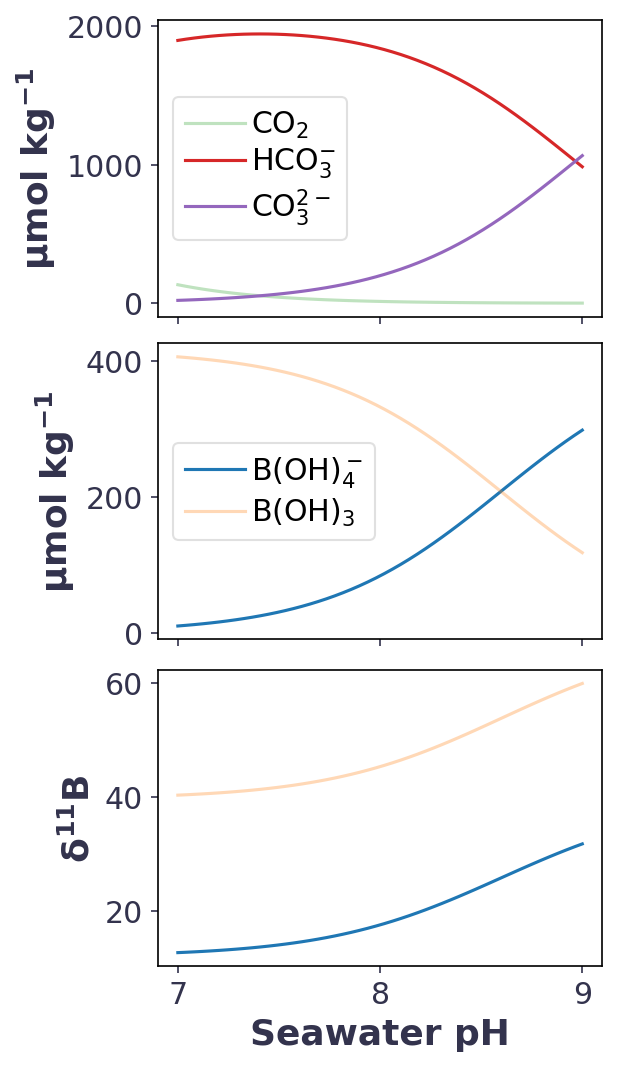

In [30]:
fig, axs = plt.subplots(3, 1, figsize=[4, 7], sharex=True, constrained_layout=True)

sw = cb.CBsys(pHtot=np.linspace(7, 9), DIC=2050, BT=416, dBT=39.61)

axs[2].plot(sw.pHtot, sw.dBO4, label='$B(OH)_4^-$')
axs[2].plot(sw.pHtot, sw.dBO3, label='$B(OH)_3$', alpha=0.3)
axs[2].set_ylabel('$\delta^{11}B$')

axs[1].plot(sw.pHtot, sw.BO4, label='$B(OH)_4^-$')
axs[1].plot(sw.pHtot, sw.BO3, label='$B(OH)_3$', alpha=0.3)
axs[1].legend()
axs[1].set_ylabel('$\mu mol~kg^{-1}$')

axs[0].plot(sw.pHtot, sw.CO2, label='$CO_2$', color='C2', alpha=0.3)
axs[0].plot(sw.pHtot, sw.HCO3, label='$HCO_3^{-}$', color='C3')
axs[0].plot(sw.pHtot, sw.CO3, label='$CO_3^{2-}$', color='C4')
axs[0].legend()
axs[0].set_ylabel('$\mu mol~kg^{-1}$')

axs[2].set_xlabel('Seawater pH')

In [31]:
np.sum(ind & iorb)

33

Text(0, 0.5, 'pH')

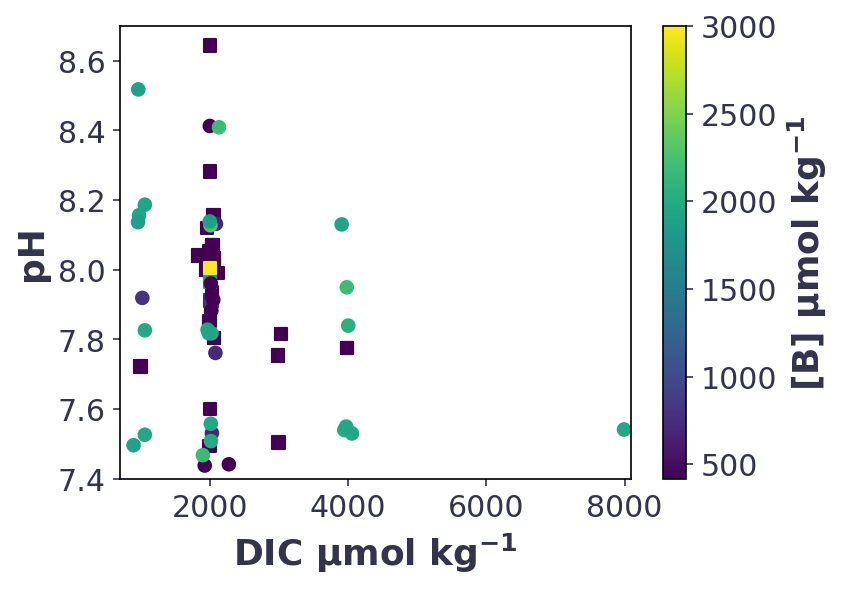

In [32]:
ind = (dat.Measured.who == 'This Study')
iorb = dat.Measured.Species == 'universa'

plt.scatter(dat.csys_mid.DIC[~ind & iorb], dat.csys_mid.pHtot[~ind & iorb], c=dat.csys_mid.BT[~ind & iorb], vmin=416, vmax=3000, marker='s')
plt.scatter(dat.csys_mid.DIC[ind & iorb], dat.csys_mid.pHtot[ind & iorb], c=dat.csys_mid.BT[ind & iorb], vmin=416, vmax=3000, marker='o')

plt.xlim(700, 8100)
plt.ylim(7.4, 8.7)

plt.colorbar(label='[B] $\mu mol~kg^{-1}$')
plt.xlabel('DIC $\mu mol~kg^{-1}$')
plt.ylabel('pH')

In [33]:
(~(dat.Measured.who == 'This Study')).sum()

85

Text(0, 0.5, 'pH')

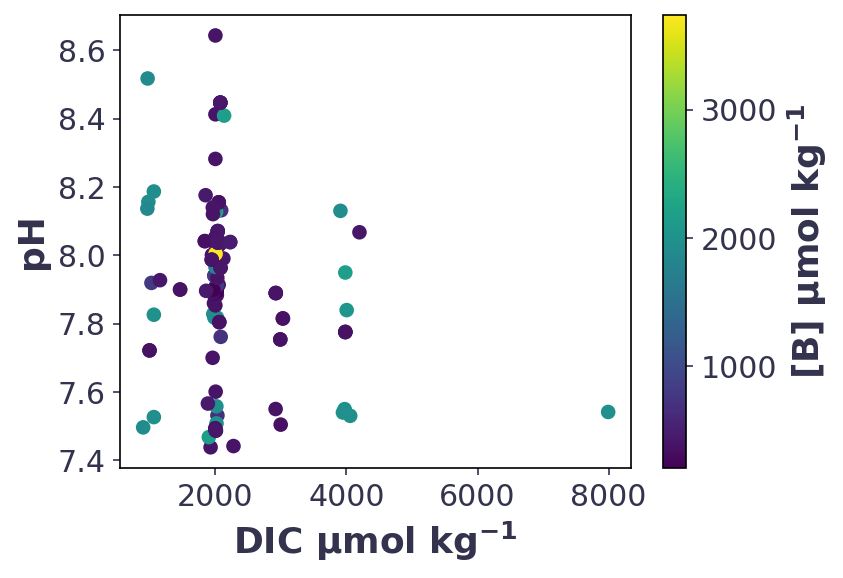

In [34]:
plt.scatter(dat.csys_mid.DIC, dat.csys_mid.pHtot, c=dat.csys_mid.BT)
plt.colorbar(label='[B] $\mu mol~kg^{-1}$')
plt.xlabel('DIC $\mu mol~kg^{-1}$')
plt.ylabel('pH')

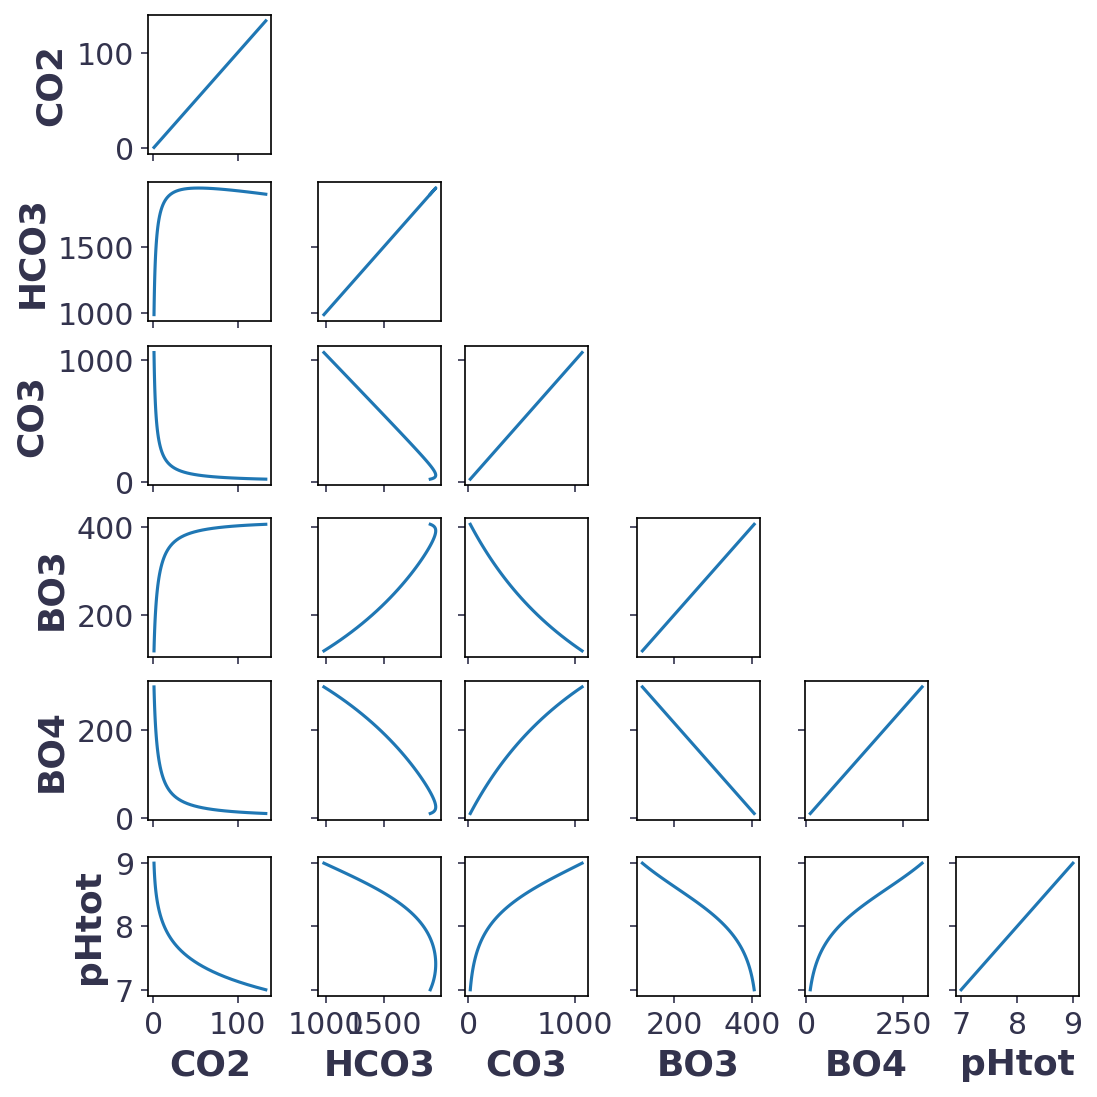

In [35]:
species = ['CO2', 'HCO3', 'CO3', 'BO3', 'BO4', 'pHtot']

fig, axs = plt.subplots(len(species), len(species), figsize=[1.2 * len(species), 1.2 * len(species)], sharex='col', sharey='row', constrained_layout=True)

for i, j in zip(*np.triu_indices(len(species))):
    axs[j,i].plot(sw[species[i]], sw[species[j]])
    
    if axs[j,i].is_last_row():
        axs[j, i].set_xlabel(species[i])
    if axs[j,i].is_first_col():
        axs[j, i].set_ylabel(species[j])

for i, j in zip(*np.tril_indices(len(species), -1)):
    axs[j,i].set_visible(False)

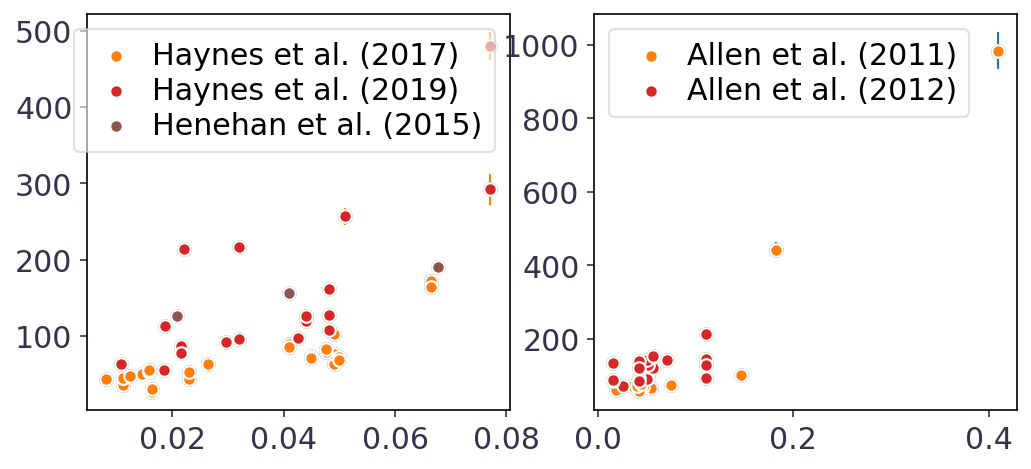

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3.5))

axd = {k: ax for k, ax in zip(['DIC', 'HCO3'], axs)}

y = unp.nominal_values(dat.Measured['B/Caf'])
y_err = unp.std_devs(dat.Measured['B/Caf'])


for k, d in denoms.items():
    ax = axd[d]
    
    ind = dat.Measured.who == k
    
    x = dat.csys_mid.BO4 / dat.csys_mid[d]
    
    ax.scatter(x[ind], y[ind])
    
    points = ax.scatter(x[ind], y[ind], lw=1, edgecolor='w', label=k)
    ax.errorbar(x[ind], y[ind], y_err[ind], lw=0, elinewidth=1, zorder=-1)
    
    
axs[0].legend()
axs[1].legend()

In [37]:
def plotline(x,y,ax,xn=None,alpha=0.3,**kwargs):
    x = np.asanyarray(x)
    y = np.asanyarray(y)
    try:
        p, cov = np.polyfit(x, y, 1, cov=True)
        up = un.correlated_values(p, cov)
        if xn is None:
            xn = np.linspace(x.min(), x.max())
        yn = np.polyval(up, xn)
        line = ax.plot(xn, nom(yn), **kwargs)[0]
        ax.fill_between(xn, nom(yn)-err(yn), nom(yn)+err(yn), alpha=alpha*0.3, **kwargs)
        return r2_score(y, np.polyval(p, x))
    except ValueError:
        return np.nan
    
    

In [38]:
denominators.keys()

dict_keys(['BT_DIC', 'BT_HCO3', 'BT_CO3', 'BO4_DIC', 'BO4_HCO3', 'BO4_CO3', 'BO4_sqrt(CO3)', 'BO4_(CO3*sqrt(Ca))', 'BO4_(HCO3*sqrt(Ca))', 'sal'])

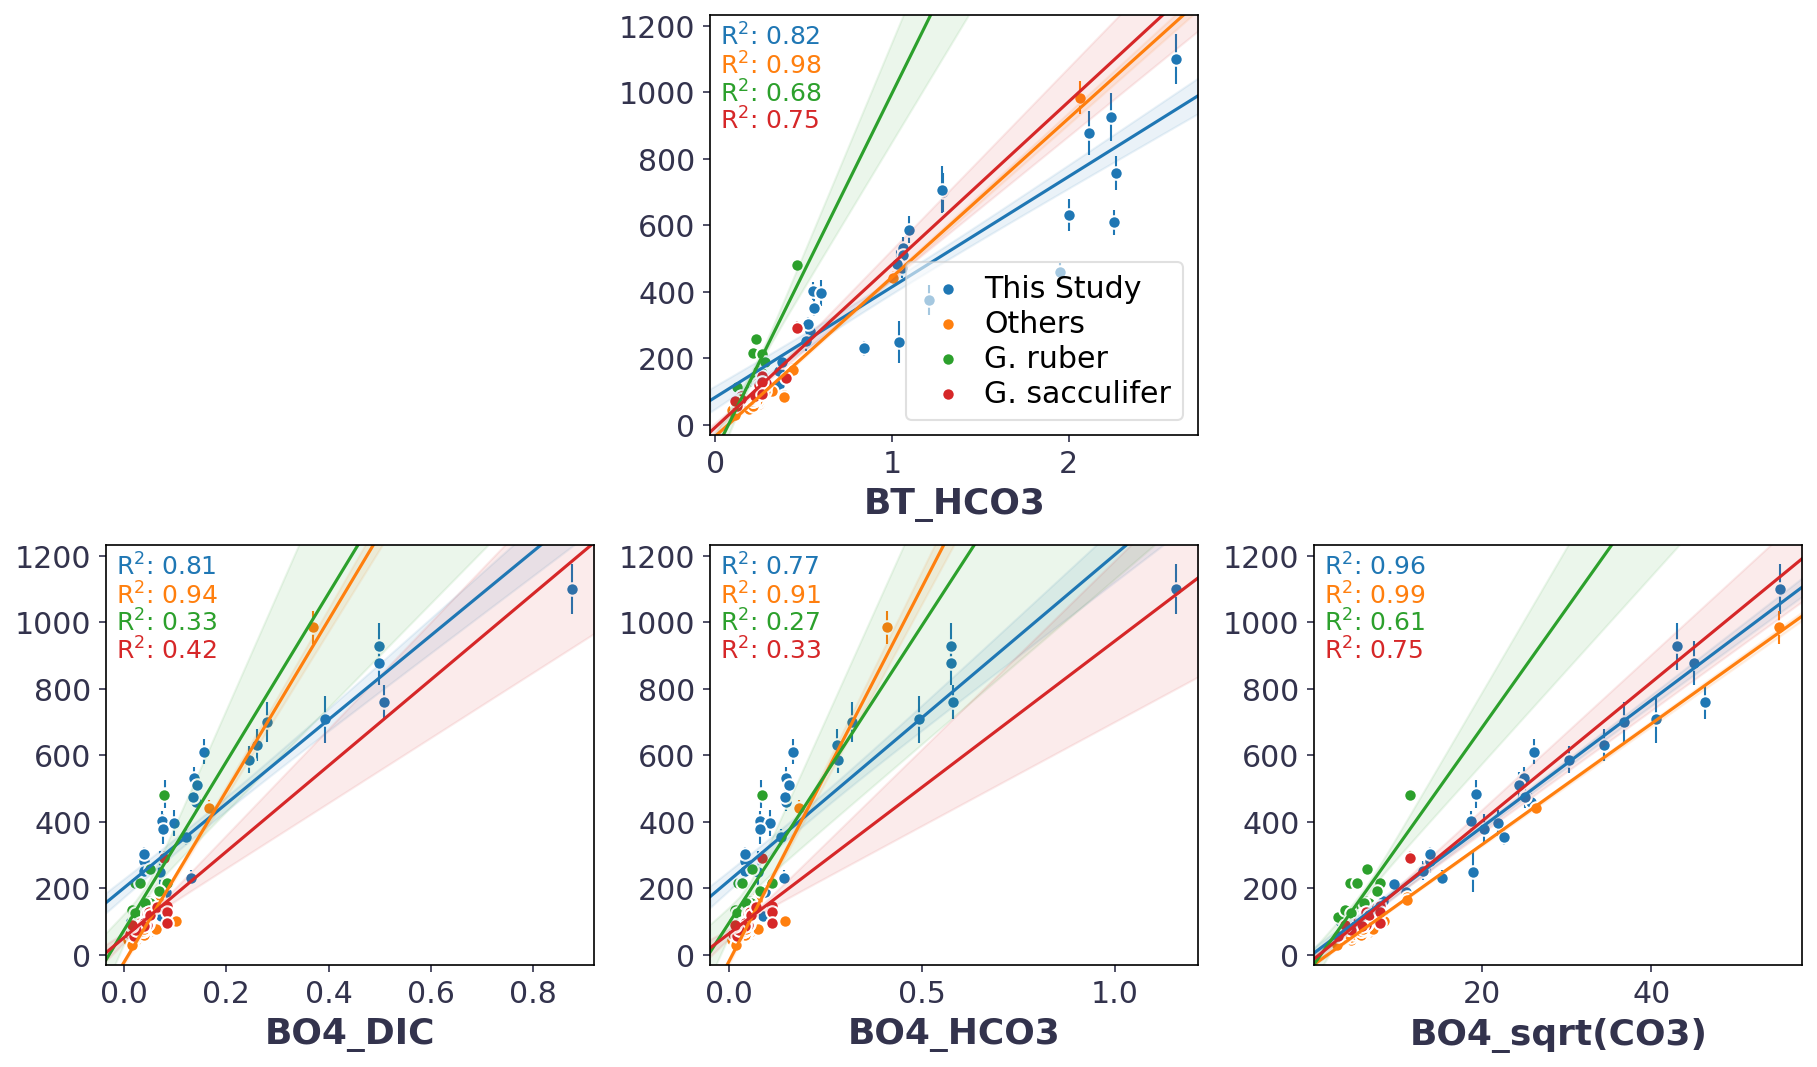

In [44]:
fig, axs = plt.subplots(2, 3, figsize=[12, 7], constrained_layout=True)#, sharey=True)

# denomkeys = ['BT_DIC', 'BT_HCO3', 'BT_CO3', 'BO4_DIC', 'BO4_HCO3', 'BO4_CO3']
denomkeys = ['BT_DIC', 'BT_HCO3', 'BT_CO3', 'BO4_DIC', 'BO4_HCO3', 'BO4_sqrt(CO3)']
# denomkeys = ['BT_DIC','BT_HCO3', 'BO4_sqrt(CO3)', 'BO4_DIC', 'BO4_HCO3', 'BO4_CO3']

y = nom(dat.loc[:, ('Measured', 'B/Caf')])
y_err = err(dat.loc[:, ('Measured', 'B/Caf')])

ind0 = (dat.Measured.who == 'This Study')

inds = {
    'This Study': ind0,
    'Others': ~ind0 & (dat.Measured.Species == 'universa'),
    'G. ruber': ~ind0 & (dat.Measured.Species == 'ruber'),
    'G. sacculifer': ~ind0 & (dat.Measured.Species == 'sacculifer'),
#     'amphis': ~ind0 & (dat.Measured.Species == 'lessonii'),
}
cs = {}
    
for k, ax in zip(denomkeys, axs.flat):
    for label, ind in inds.items():
        points = ax.scatter(denominators[k][ind], y[ind], lw=1, edgecolor='w', label=label)
        ax.errorbar(denominators[k][ind], y[ind], y_err[ind], lw=0, elinewidth=1, zorder=-1)
        cs[label] = points.get_facecolor()[0]
      
    xn = np.linspace(*ax.get_xlim())
    ax.set_xlim(ax.get_xlim())
    ax.set_ylim(ax.get_ylim())
    prepend = ''
    for label, ind in inds.items():
        r2 = plotline(denominators[k][ind], y[ind],ax,xn=xn,color=cs[label])
        ax.text(.02, .98, f'{prepend}$R^2$: {r2:.2f}', ha='left', va='top', transform=ax.transAxes, color=cs[label])
        prepend += '\n'
    ax.set_xlabel(k)

axs[0,0].set_visible(False)
axs[0,2].set_visible(False)

axs[0,1].legend(loc='lower right')


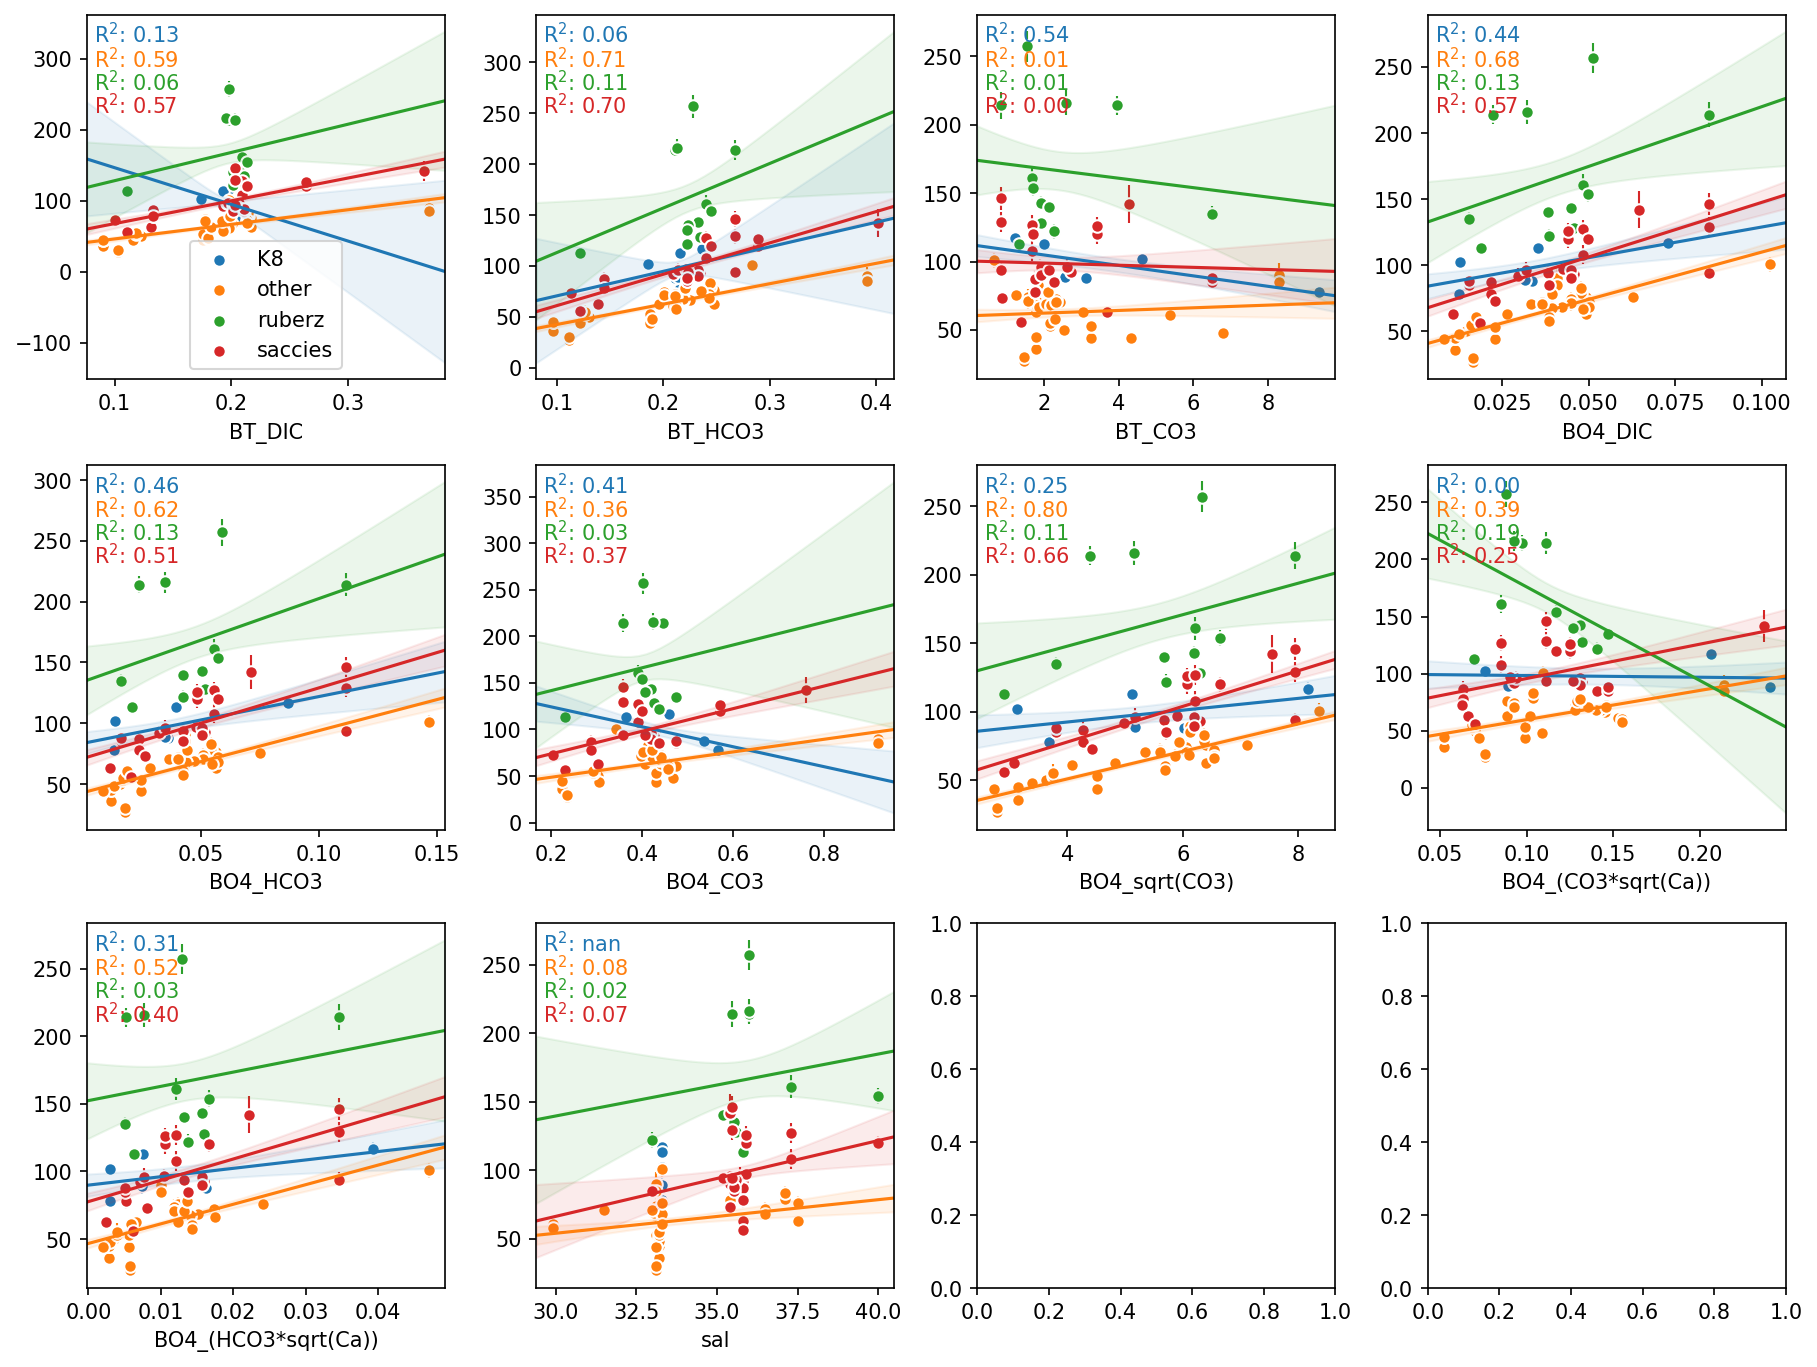

In [61]:
fig, axs = plt.subplots(3, 4, figsize=[12, 9], constrained_layout=True)#, sharey=True)

y = nom(dat.loc[:, ('Measured', 'B/Caf')])
y_err = err(dat.loc[:, ('Measured', 'B/Caf')])

ind0 = (dat.Measured.who == 'This Study')

inds = {
    'K8': ind0,
    'other': ~ind0 & (dat.Measured.Species == 'universa'),
    'ruberz': ~ind0 & (dat.Measured.Species == 'ruber'),
    'saccies': ~ind0 & (dat.Measured.Species == 'sacculifer')
}
inds = {k: v & (dat.csys_mid.BT < 500) for k, v in inds.items()}
cs = {}
    
for k, ax in zip(denominators.keys(), axs.flat):
    for label, ind in inds.items():
        points = ax.scatter(denominators[k][ind], y[ind], lw=1, edgecolor='w', label=label)
        ax.errorbar(denominators[k][ind], y[ind], y_err[ind], lw=0, elinewidth=1, zorder=-1)
        cs[label] = points.get_facecolor()[0]
      
    xn = np.linspace(*ax.get_xlim())
    ax.set_xlim(ax.get_xlim())
    prepend = ''
    for label, ind in inds.items():
        r2 = plotline(denominators[k][ind], y[ind],ax,xn=xn,color=cs[label])
        ax.text(.02, .98, f'{prepend}$R^2$: {r2:.2f}', ha='left', va='top', transform=ax.transAxes, color=cs[label])
        prepend += '\n'

    ax.set_xlabel(k)

axs[0,0].legend()


## Resi plot for BO4/sqrt(CO3)

In [93]:
load.b_data()

csys_var = 'csys_mid'

extras = [
    ('Measured', '[Ca]sw'),
    ('Measured', '[Mg]sw'),
#     ('Measured', 'Temp'),
#     (csys_var, 'Omega'),
    (csys_var, 'BO4'),
    (csys_var, 'BT'),
    (csys_var, 'CO3'),
    (csys_var, 'pHtot'),
    (csys_var, 'DIC'),
#     (csys_var, 'del_CO3'),
]

ratio = 'BO4_sqrt(CO3)'
print(f'KB Denominator: {ratio}')
candidates = dat.loc[:, extras]
y0 = dat.loc[:, ('Measured', 'B/Caf')]
yu = y0 / denominators[ratio]
y = nom(yu)
w = 1 / err(yu)**2
brute = bf.Brute(X=candidates.values, y=y, w=w, varnames=[c[1] for c in candidates.columns], max_interaction_order=0, scale_data=True, Scaler=StandardScaler)
_ = brute.evaluate_polynomials()

KB Denominator: BO4_sqrt(CO3)


Evaluating Models::   0%|          | 0/128 [00:00<?, ?it/s]

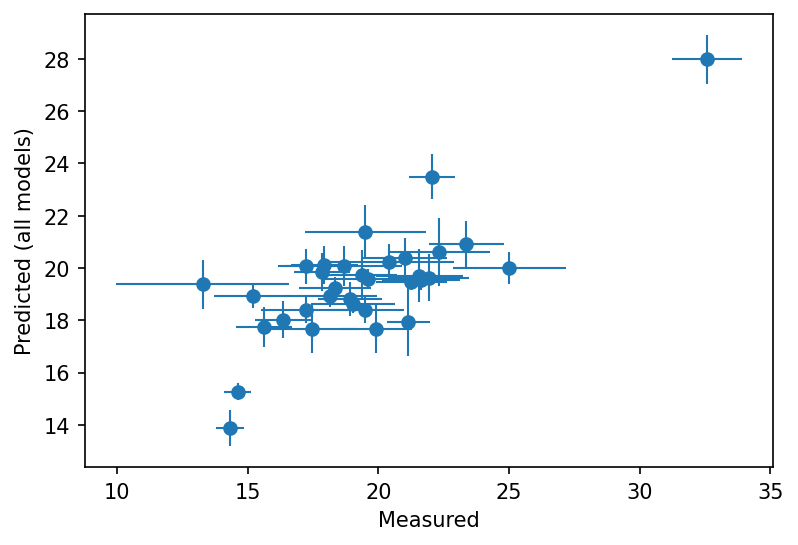

In [94]:
brute.plot_obs_vs_pred()

## If going full empiribro, should expand to coretops and etc.

Wich means...

- Yu
- Hoenisch
- Rae
- Henehan
- Foster

In [30]:
ct = pd.read_csv('data/coretops/coretops_compiled.csv', header=[0,1])

In [31]:
ct_denominators = {}
ct_KBs = {}
y = ct.loc[:, ('measured', 'B/Ca')]
for b in ['BT', 'BO4']:
    for c in ['DIC', 'HCO3', 'CO3']:
        ratio = f'{b}_{c}'
        ct_denominators[ratio] = (ct.loc[:, ('calculated', b)] / ct.loc[:, ('calculated', c)])
        ct_KBs[ratio] = y / ct_denominators[ratio]

ratio = 'BO4_sqrt(CO3)'
ct_denominators[ratio] = (ct.loc[:, ('calculated', 'BO4')] / ct.loc[:, ('calculated', 'CO3')]**0.5)
ct_KBs[ratio] = y / ct_denominators[ratio]

# Andy logic
ratio = 'BO4_(CO3*sqrt(Ca))'
ct_denominators[ratio] = (ct.loc[:, ('calculated', 'BO4')] / (ct.loc[:, ('calculated', 'CO3')] * dat.loc[:, ('Measured', '[Ca]sw')]**0.5))
ct_KBs[ratio] = y / ct_denominators[ratio]

ratio = 'BO4_(HCO3*sqrt(Ca))'
ct_denominators[ratio] = (ct.loc[:, ('calculated', 'BO4')] / (ct.loc[:, ('calculated', 'HCO3')] * dat.loc[:, ('Measured', '[Ca]sw')]**0.5))
ct_KBs[ratio] = y / denominators[ratio]

ct_denominators['sal'] = ct.loc[:, ('calculated', 'S_in')]

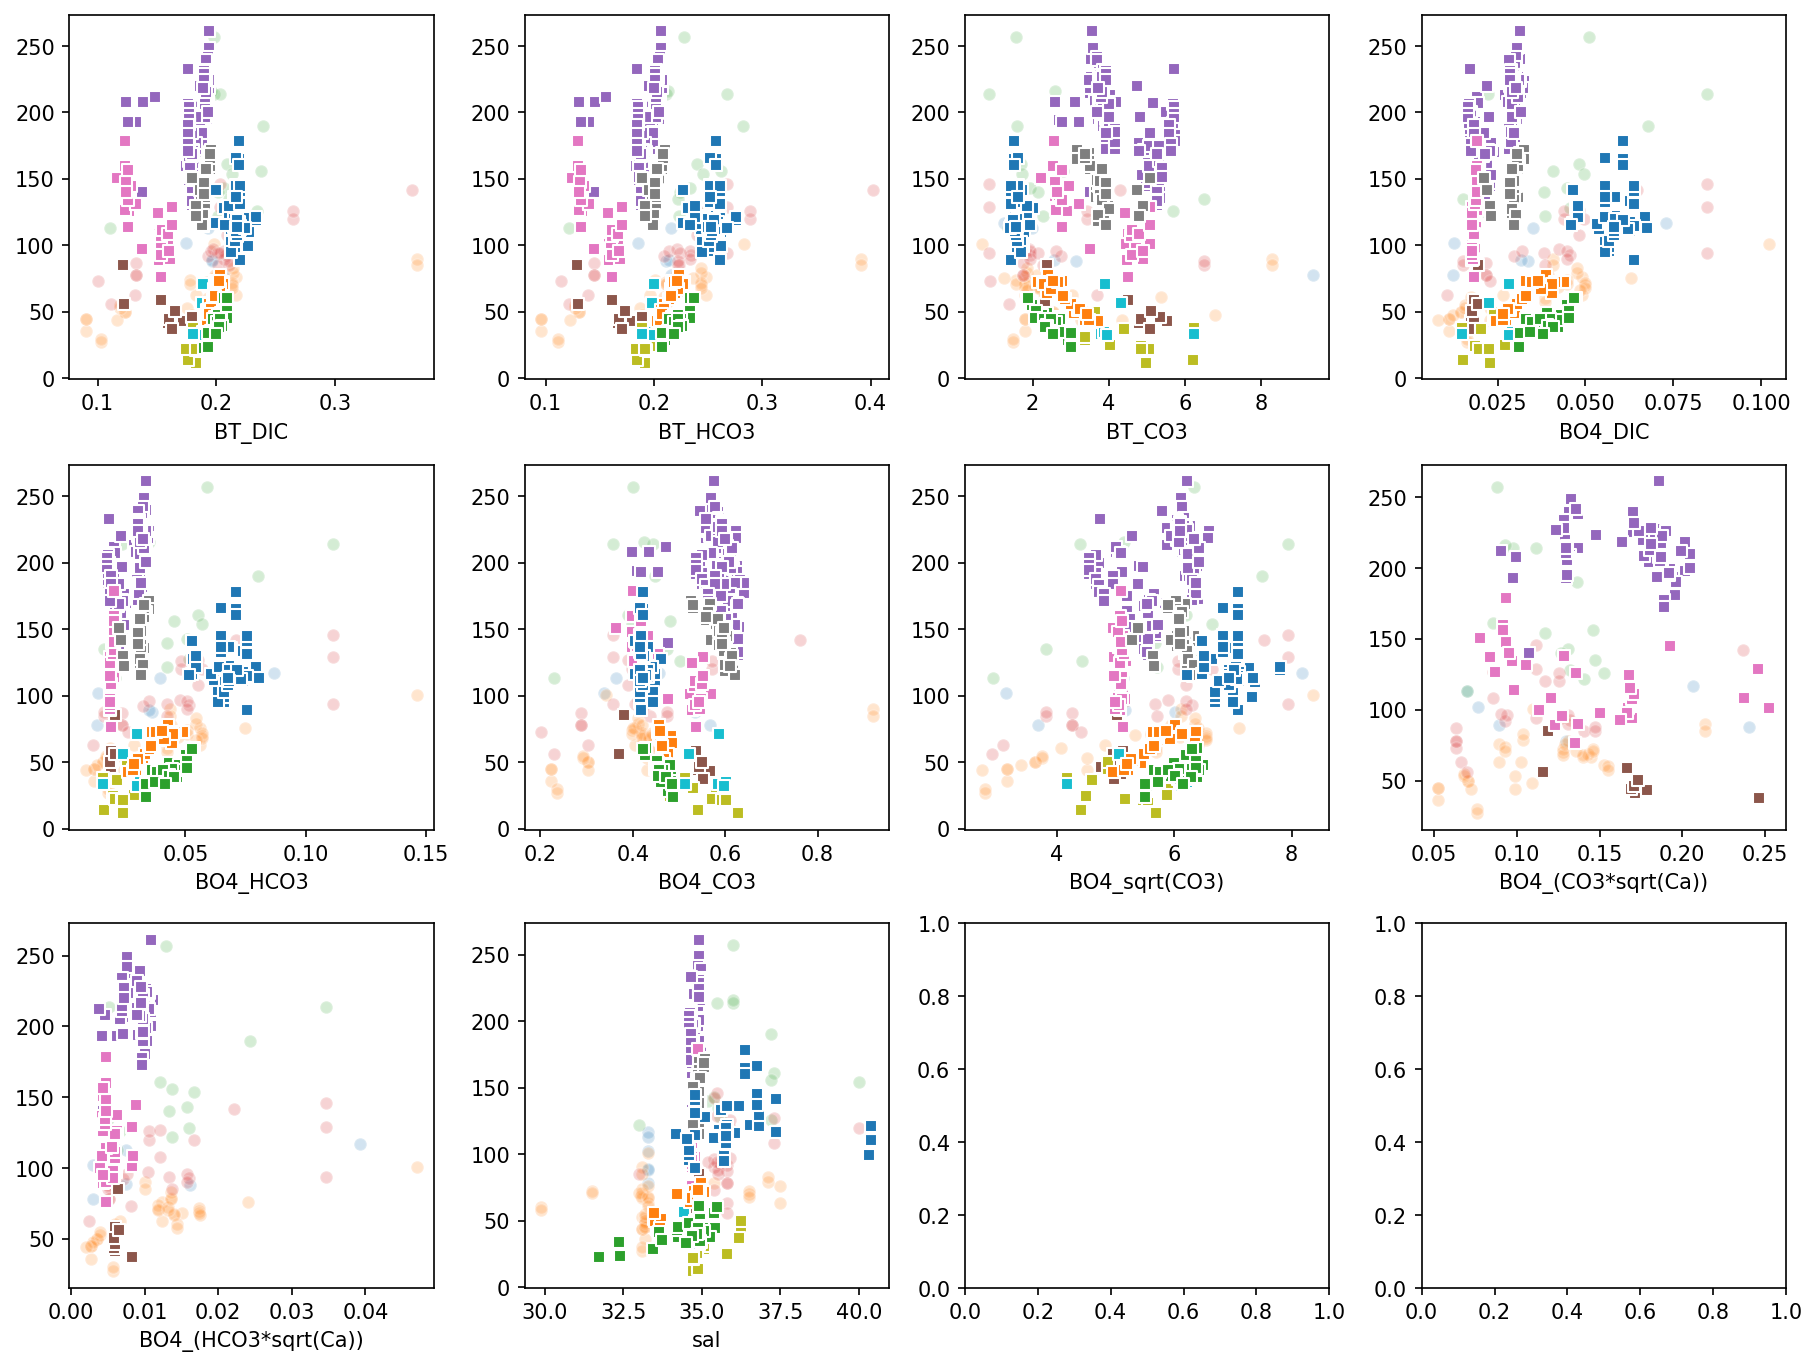

In [32]:
fig, axs = plt.subplots(3, 4, figsize=[12, 9], constrained_layout=True)#, sharey=True)

y = nom(dat.loc[:, ('Measured', 'B/Caf')])
y_err = err(dat.loc[:, ('Measured', 'B/Caf')])

ind0 = (dat.Measured.who == 'This Study')

inds = {
    'K8': ind0,
    'other': ~ind0 & (dat.Measured.Species == 'universa'),
    'ruberz': ~ind0 & (dat.Measured.Species == 'ruber'),
    'saccies': ~ind0 & (dat.Measured.Species == 'sacculifer')
}
inds = {k: v & (dat.csys_mid.BT < 500) for k, v in inds.items()}
cs = {}

k = 'BO4_sqrt(CO3)'

for k, ax in zip(denominators.keys(), axs.flat):
    for label, ind in inds.items():
        points = ax.scatter(denominators[k][ind], y[ind], lw=1, edgecolor='w', label=label, alpha=0.2)
    #     ax.errorbar(denominators[k][ind], y[ind], y_err[ind], lw=0, elinewidth=1, zorder=-1)
        cs[label] = points.get_facecolor()[0]

#     xn = np.linspace(*ax.get_xlim())
#     ax.set_xlim(ax.get_xlim())
#     prepend = ''
#     for label, ind in inds.items():
#         r2 = plotline(denominators[k][ind], y[ind],ax,xn=xn,color=cs[label], alpha=0.1)
#         ax.text(.02, .98, f'{prepend}$R^2$: {r2:.2f}', ha='left', va='top', transform=ax.transAxes, color=cs[label])
#         prepend += '\n'

    ax.set_xlabel(k)

    for s in ct.metadata.species.unique():
        ind = ct.metadata.species == s
        ax.scatter(ct_denominators[k][ind], ct.measured['B/Ca'][ind], label=s, lw=1, marker='s', edgecolor='w')
    
# ax.legend(bbox_to_anchor=(1, 0., 0, 1))

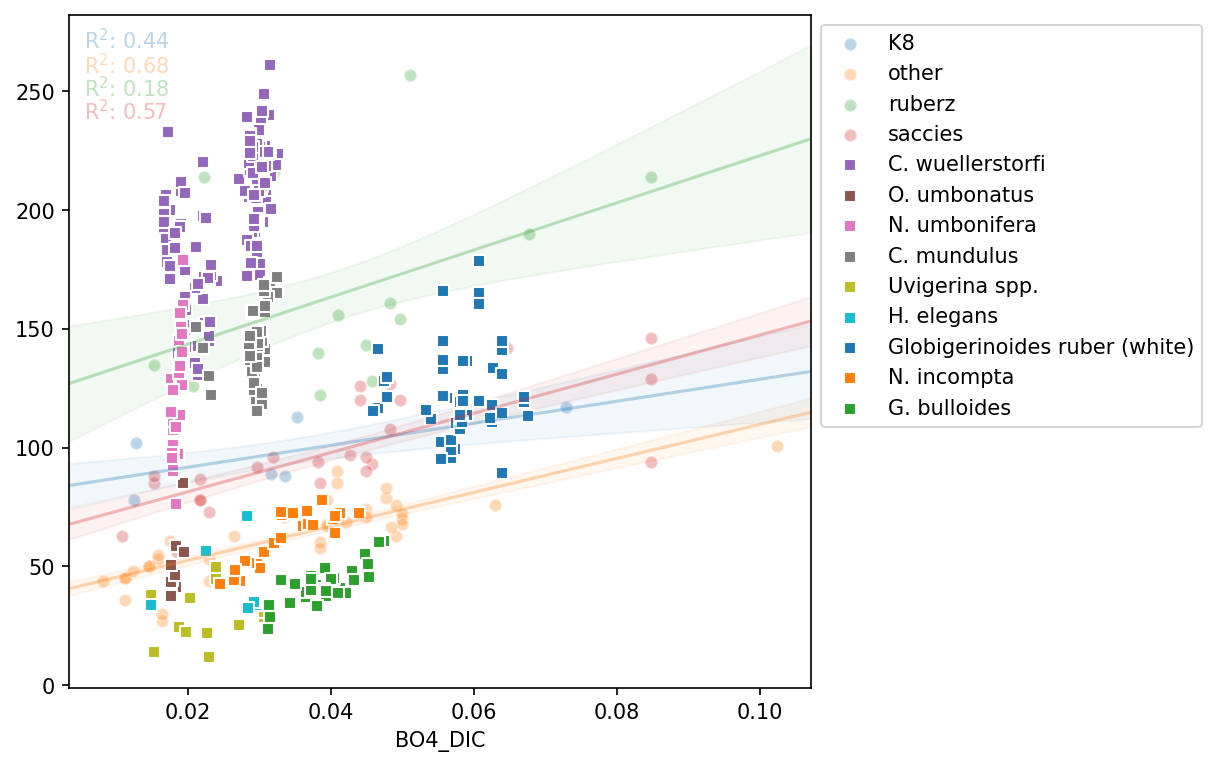

In [33]:
fig, ax = plt.subplots(1, 1, figsize=[8, 5], constrained_layout=True)#, sharey=True)

y = nom(dat.loc[:, ('Measured', 'B/Caf')])
y_err = err(dat.loc[:, ('Measured', 'B/Caf')])

ind0 = (dat.Measured.who == 'This Study')

inds = {
    'K8': ind0,
    'other': ~ind0 & (dat.Measured.Species == 'universa'),
    'ruberz': ~ind0 & (dat.Measured.Species == 'ruber'),
    'saccies': ~ind0 & (dat.Measured.Species == 'sacculifer')
}
inds = {k: v & (dat.csys_mid.BT < 500) for k, v in inds.items()}
cs = {}

k = 'BO4_DIC'
for label, ind in inds.items():
    points = ax.scatter(denominators[k][ind], y[ind], lw=1, edgecolor='w', label=label, alpha=0.3)
#     ax.errorbar(denominators[k][ind], y[ind], y_err[ind], lw=0, elinewidth=1, zorder=-1)
    cs[label] = points.get_facecolor()[0]

xn = np.linspace(*ax.get_xlim())
ax.set_xlim(ax.get_xlim())
prepend = ''
for label, ind in inds.items():
    r2 = plotline(denominators[k][ind], y[ind],ax,xn=xn,color=cs[label], alpha=0.2)
    ax.text(.02, .98, f'{prepend}$R^2$: {r2:.2f}', ha='left', va='top', transform=ax.transAxes, color=cs[label])
    prepend += '\n'

ax.set_xlabel(k)

for s in ct.metadata.species.unique():
    ind = ct.metadata.species == s
    plt.scatter(ct.calculated.BO4[ind] / ct.calculated.DIC[ind], ct.measured['B/Ca'][ind], label=s, lw=1, marker='s', edgecolor='w')
    
ax.legend(bbox_to_anchor=(1, 0., 0, 1))

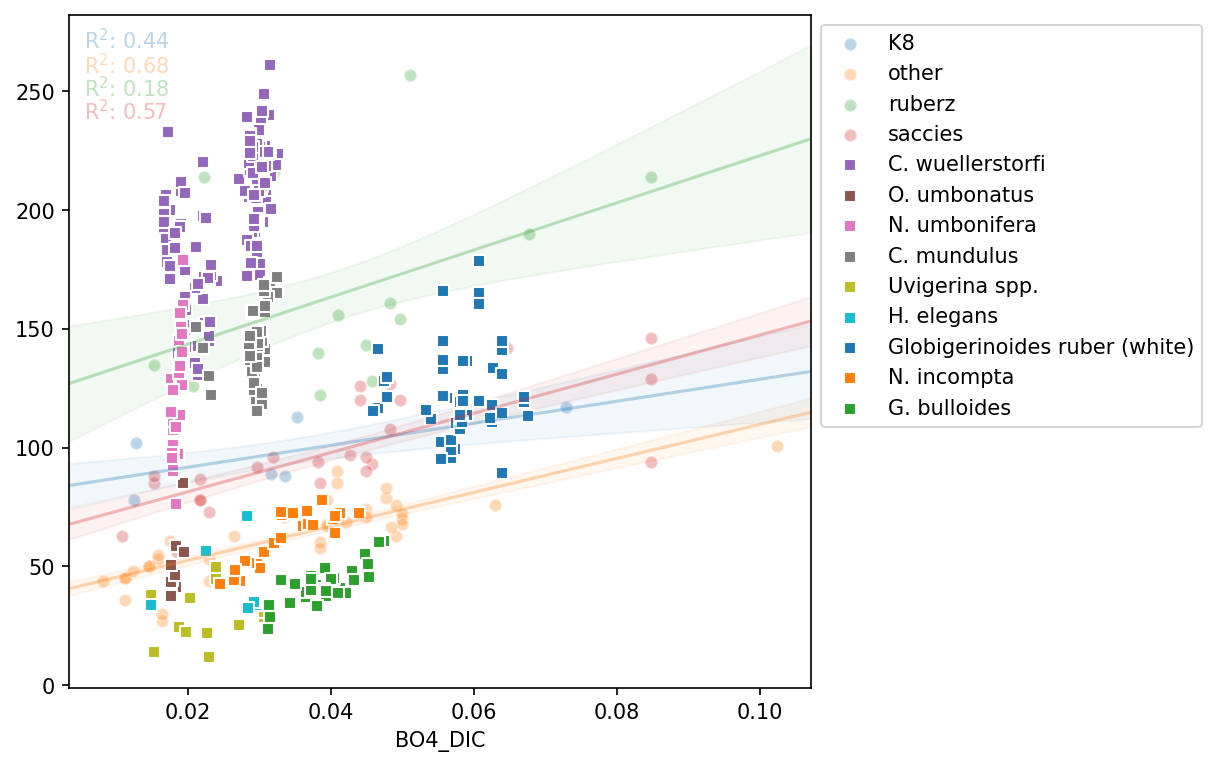

In [34]:
fig, ax = plt.subplots(1, 1, figsize=[8, 5], constrained_layout=True)#, sharey=True)

y = nom(dat.loc[:, ('Measured', 'B/Caf')])
y_err = err(dat.loc[:, ('Measured', 'B/Caf')])

ind0 = (dat.Measured.who == 'This Study')

inds = {
    'K8': ind0,
    'other': ~ind0 & (dat.Measured.Species == 'universa'),
    'ruberz': ~ind0 & (dat.Measured.Species == 'ruber'),
    'saccies': ~ind0 & (dat.Measured.Species == 'sacculifer')
}
inds = {k: v & (dat.csys_mid.BT < 500) for k, v in inds.items()}
cs = {}

k = 'BO4_DIC'
for label, ind in inds.items():
    points = ax.scatter(denominators[k][ind], y[ind], lw=1, edgecolor='w', label=label, alpha=0.3)
#     ax.errorbar(denominators[k][ind], y[ind], y_err[ind], lw=0, elinewidth=1, zorder=-1)
    cs[label] = points.get_facecolor()[0]

xn = np.linspace(*ax.get_xlim())
ax.set_xlim(ax.get_xlim())
prepend = ''
for label, ind in inds.items():
    r2 = plotline(denominators[k][ind], y[ind],ax,xn=xn,color=cs[label], alpha=0.2)
    ax.text(.02, .98, f'{prepend}$R^2$: {r2:.2f}', ha='left', va='top', transform=ax.transAxes, color=cs[label])
    prepend += '\n'

ax.set_xlabel(k)

for s in ct.metadata.species.unique():
    ind = ct.metadata.species == s
    plt.scatter(ct.calculated.BO4[ind] / ct.calculated.DIC[ind], ct.measured['B/Ca'][ind], label=s, lw=1, marker='s', edgecolor='w')
    
ax.legend(bbox_to_anchor=(1, 0., 0, 1))

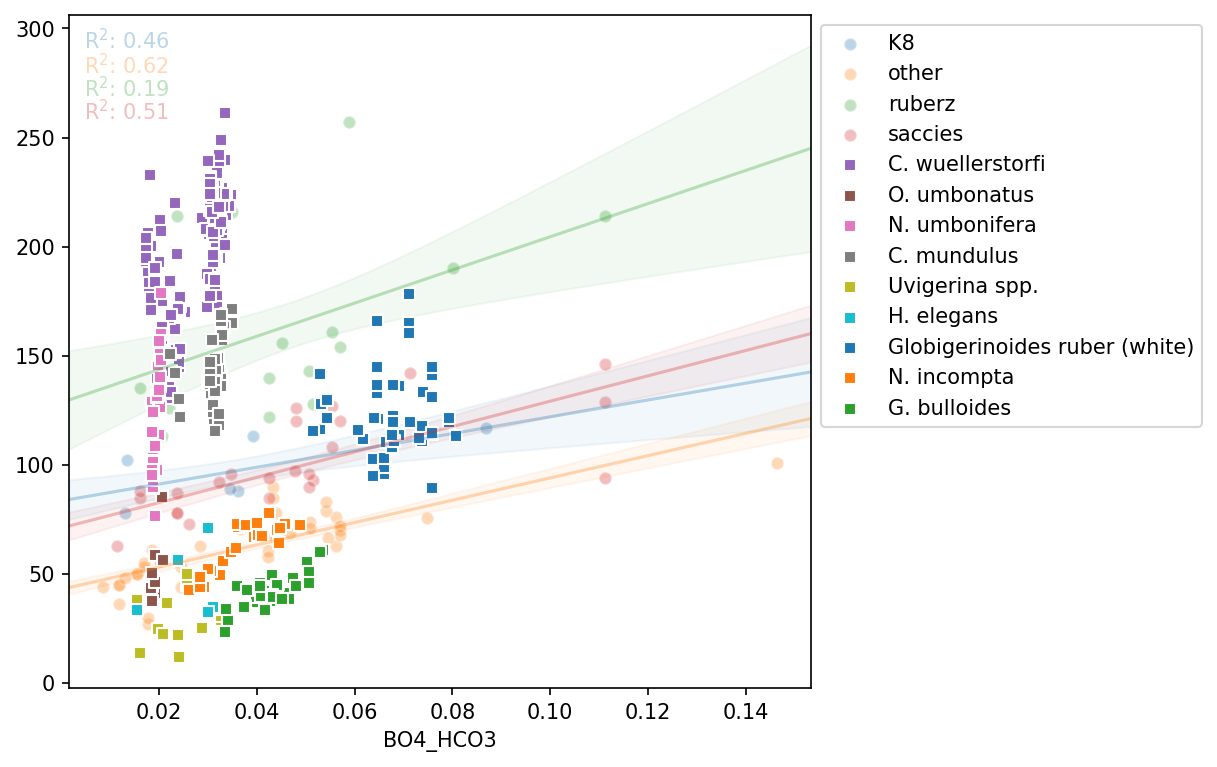

In [35]:
fig, ax = plt.subplots(1, 1, figsize=[8, 5], constrained_layout=True)#, sharey=True)

y = nom(dat.loc[:, ('Measured', 'B/Caf')])
y_err = err(dat.loc[:, ('Measured', 'B/Caf')])

ind0 = (dat.Measured.who == 'This Study')

inds = {
    'K8': ind0,
    'other': ~ind0 & (dat.Measured.Species == 'universa'),
    'ruberz': ~ind0 & (dat.Measured.Species == 'ruber'),
    'saccies': ~ind0 & (dat.Measured.Species == 'sacculifer')
}
inds = {k: v & (dat.csys_mid.BT < 500) for k, v in inds.items()}
cs = {}

k = 'BO4_HCO3'
for label, ind in inds.items():
    points = ax.scatter(denominators[k][ind], y[ind], lw=1, edgecolor='w', label=label, alpha=0.3)
#     ax.errorbar(denominators[k][ind], y[ind], y_err[ind], lw=0, elinewidth=1, zorder=-1)
    cs[label] = points.get_facecolor()[0]

xn = np.linspace(*ax.get_xlim())
ax.set_xlim(ax.get_xlim())
prepend = ''
for label, ind in inds.items():
    r2 = plotline(denominators[k][ind], y[ind],ax,xn=xn,color=cs[label], alpha=0.2)
    ax.text(.02, .98, f'{prepend}$R^2$: {r2:.2f}', ha='left', va='top', transform=ax.transAxes, color=cs[label])
    prepend += '\n'

ax.set_xlabel(k)

for s in ct.metadata.species.unique():
    ind = ct.metadata.species == s
    plt.scatter(ct.calculated.BO4[ind] / ct.calculated.HCO3[ind], ct.measured['B/Ca'][ind], label=s, lw=1, marker='s', edgecolor='w')
    
ax.legend(bbox_to_anchor=(1, 0., 0, 1))

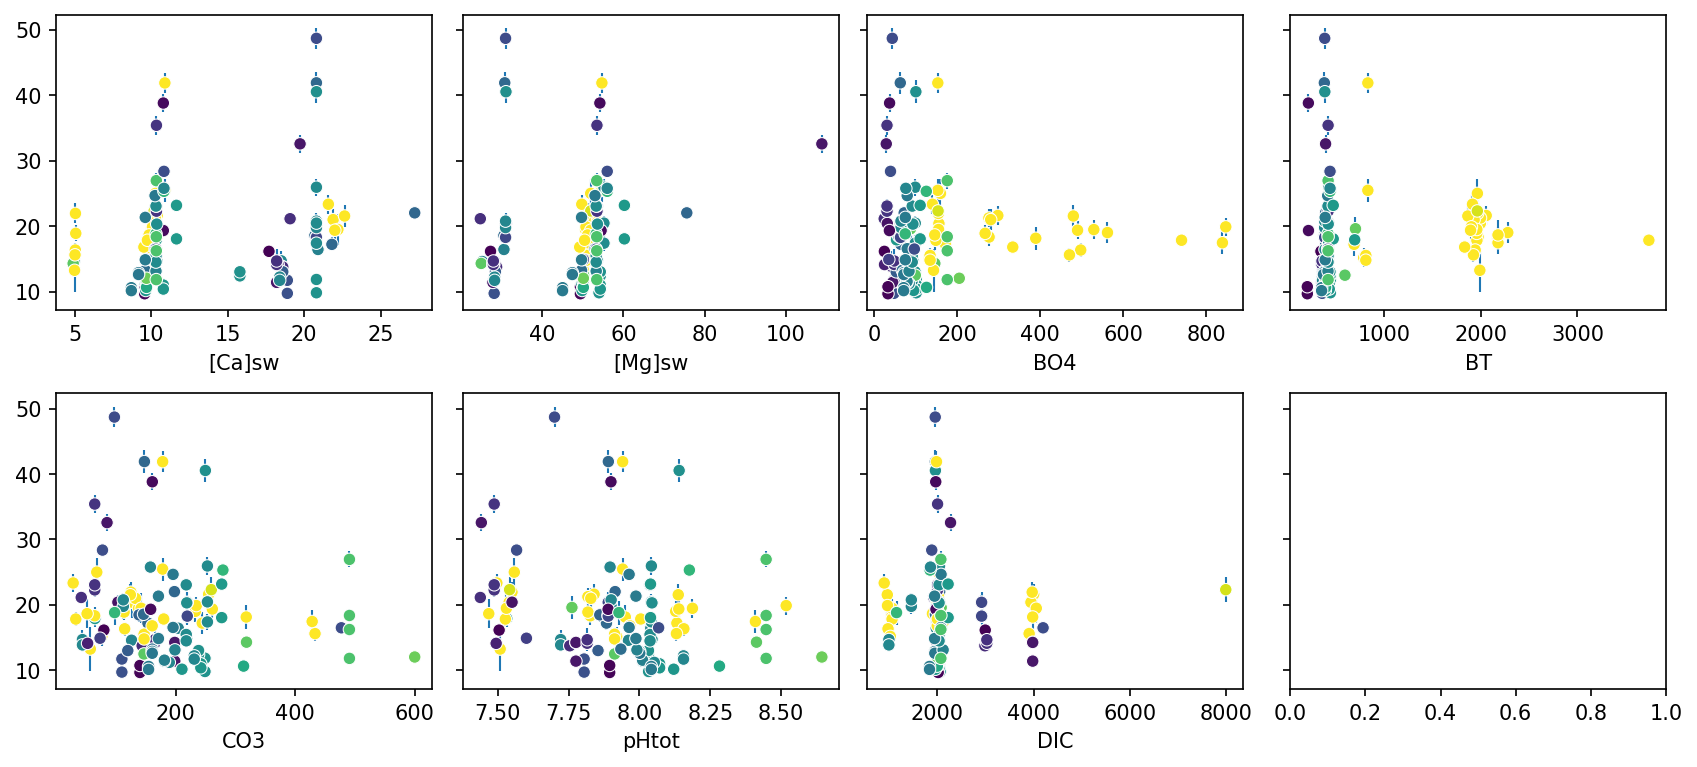

In [36]:
# residuals against partitioning

K = KBs['BO4_sqrt(CO3)']

extras = [
    ('Measured', '[Ca]sw'),
    ('Measured', '[Mg]sw'),
#     ('Measured', 'Temp'),
#     ('csys_mid', 'Omega'),
    ('csys_mid', 'BO4'),
    ('csys_mid', 'BT'),
    ('csys_mid', 'CO3'),
    ('csys_mid', 'pHtot'),
    ('csys_mid', 'DIC'),
#     ('csys_mid', 'del_CO3'),
]

ncol = 4
nrow = len(extras) // ncol
if len(extras) % ncol > 0:
    nrow += 1
    
fig, axs = plt.subplots(nrow, ncol, figsize=[ncol * 2.8, nrow * 2.5], constrained_layout=True, sharey=True)

for e, ax in zip(extras, axs.flat):
    ax.scatter(dat.loc[:, e], nom(K), lw=0.5, edgecolor='w', c=denominators['BO4_sqrt(CO3)'], vmax=10)
    ax.errorbar(dat.loc[:, e], nom(K), err(K), lw=0, elinewidth=1, zorder=-1)
    ax.set_xlabel(e[-1])

## Calculate Best Fits for all partitioning

In [95]:
csys_var = 'csys_mid'

extras = [
    ('Measured', '[Ca]sw'),
    ('Measured', '[Mg]sw'),
#     ('Measured', 'Temp'),
#     (csys_var, 'Omega'),
    (csys_var, 'BO4'),
    (csys_var, 'BT'),
    (csys_var, 'CO3'),
    (csys_var, 'pHtot'),
    (csys_var, 'DIC'),
#     (csys_var, 'del_CO3'),
]

brutes = {}

exclude_denominator = False
exclude_numerator = False

y0 = dat.loc[:, ('Measured', 'B/Caf')]

for b in ['BT', 'BO4']:
    iextras = extras
    if exclude_numerator:
        iextras = [e for e in iextras if e[1] != b]
    for c in ['DIC', 'HCO3', 'CO3']:
        if b == 'BT' and c == 'CO3':
            continue
        if exclude_denominator:
            iextras = [e for e in iextras if e[1] != c]
        ratio = f'{b}_{c}'
        print(f'KB Denominator: {ratio}')
        candidates = dat.loc[:, iextras]
        yu = y0 / denominators[ratio]
        y = nom(yu)
        w = 1 / err(yu)**2

        brutes[ratio] = bf.Brute(X=candidates.values, y=y, w=w, varnames=[c[1] for c in candidates.columns], max_interaction_order=0, Scaler=StandardScaler)
        _ = brutes[ratio].evaluate_polynomials()
    
# bo4 / sqrt(co3)
ratio = 'BO4_sqrt(CO3)'
b = 'BO4'
c = 'CO3'
iextras = extras
if exclude_denominator:
    iextras = [e for e in iextras if e[1] != c]
if exclude_numerator:
    iextras = [e for e in iextras if e[1] != b]
print(f'KB Denominator: {ratio}')
candidates = dat.loc[:, iextras]
yu = y0 / denominators[ratio]
y = nom(yu)
w = 1 / err(yu)**2
brutes[ratio] = bf.Brute(X=candidates.values, y=y, w=w, varnames=[c[1] for c in candidates.columns], max_interaction_order=0, scale_data=True, Scaler=StandardScaler)
_ = brutes[ratio].evaluate_polynomials()

KB Denominator: BT_DIC


Evaluating Models::   0%|          | 0/128 [00:00<?, ?it/s]

KB Denominator: BT_HCO3


Evaluating Models::   0%|          | 0/128 [00:00<?, ?it/s]

KB Denominator: BO4_DIC


Evaluating Models::   0%|          | 0/128 [00:00<?, ?it/s]

KB Denominator: BO4_HCO3


Evaluating Models::   0%|          | 0/128 [00:00<?, ?it/s]

KB Denominator: BO4_CO3


Evaluating Models::   0%|          | 0/128 [00:00<?, ?it/s]

KB Denominator: BO4_sqrt(CO3)


Evaluating Models::   0%|          | 0/128 [00:00<?, ?it/s]

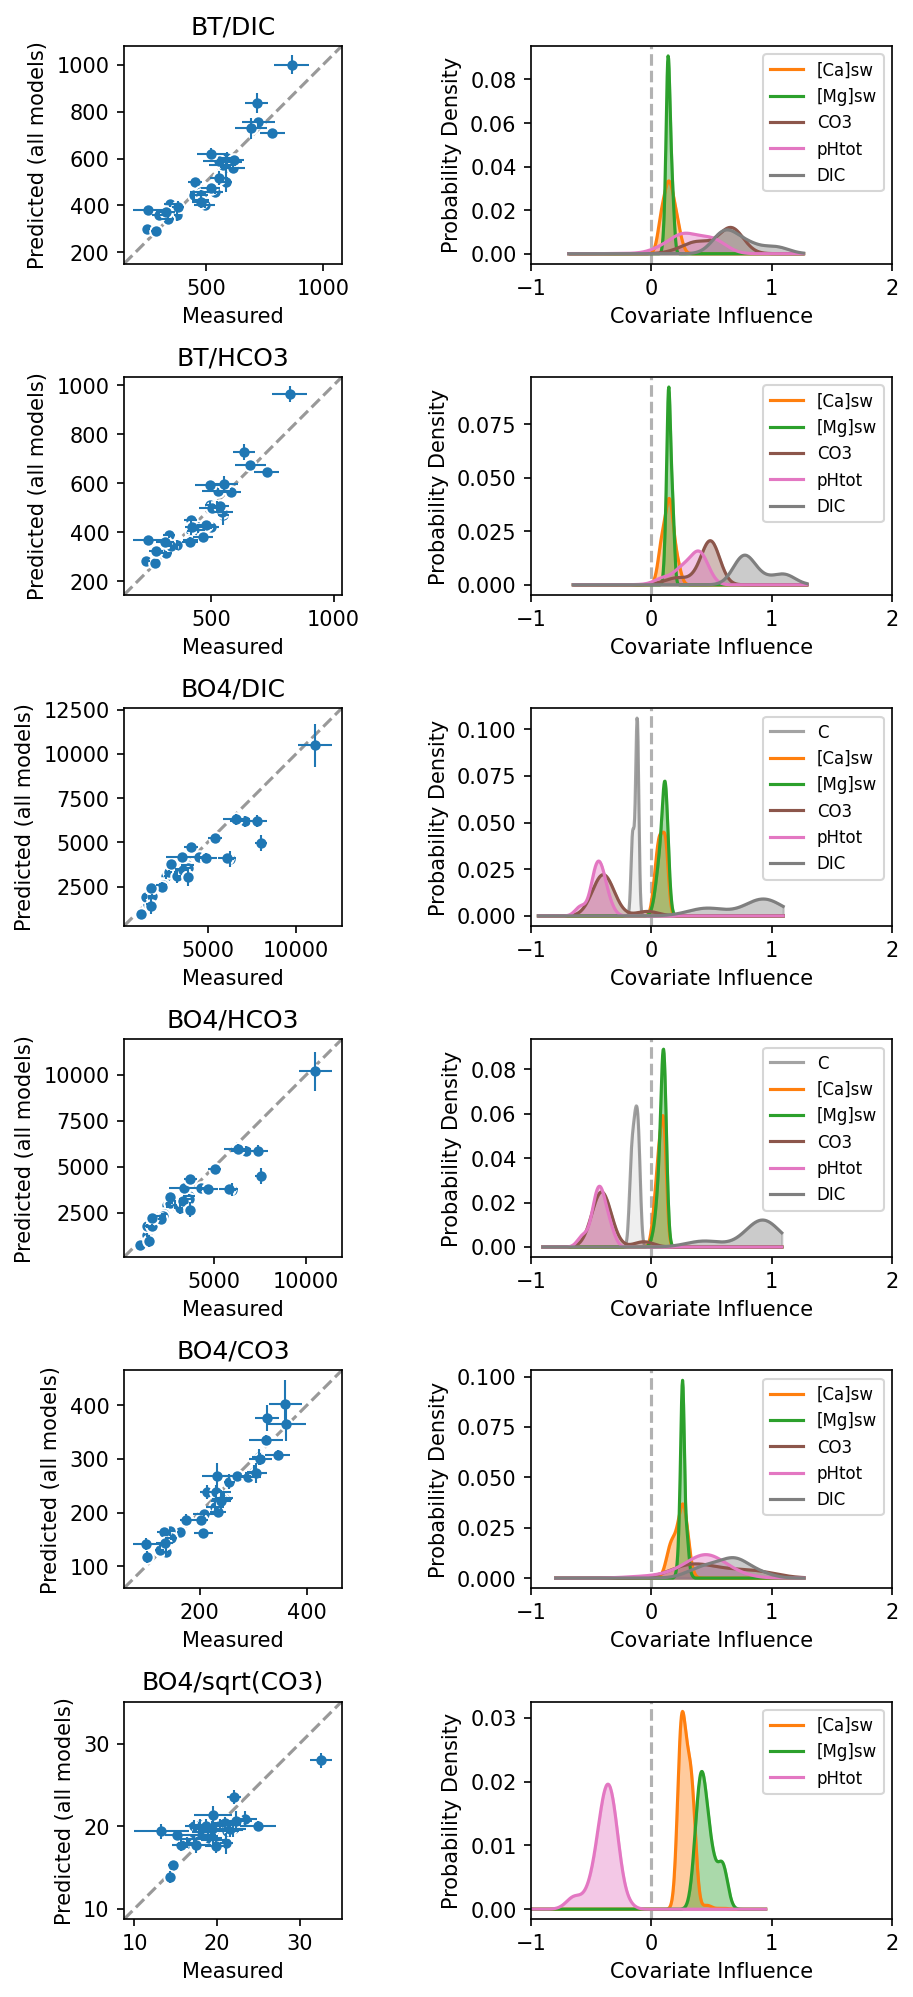

In [96]:
fig, axs = plt.subplots(len(brutes), 2, figsize=[6, 2.2 * len(brutes)], constrained_layout=True)

p_level = 0.05

for i, k in enumerate(brutes.keys()):
    pax, dax = axs[i]
    b = brutes[k]
    
    b.plot_obs_vs_pred(ax=pax, lw=1, edgecolor='w')
    lim = [min(pax.get_xlim()[0], pax.get_ylim()[0]),
           max(pax.get_xlim()[1], pax.get_ylim()[1])]
    pax.set_xlim(lim)
    pax.set_ylim(lim)
    pax.plot(lim, lim, ls='dashed', color=(0,0,0,0.4), zorder=-1)
    
    b.plot_param_dists(ax=dax, filter_zeros=p_level)
    dax.legend(fontsize=8)
    dax.set_xlim(-1, 2)
    
    pax.set_title(k.replace('_','/'))

Add panels to right showing influence of each identified significant effect.

In [39]:
# aggregate fits
df = []
for r, b in brutes.items():
    tdf = b.modelfits
    tdf['r'] = r
    df.append(tdf)
         
df = pd.concat(df)

# calculate global metrics
df.loc[:, ('metrics', 'BF_max')] = df.loc[:, ('metrics', 'BF0')] / df.loc[:, ('metrics', 'BF0')].max()
df.loc[:, ('metrics', 'K')] = 1 / df.loc[:, ('metrics', 'BF_max')]
df.loc[:, ('metrics', 'evidence_against')] = None

df.sort_values(('metrics', 'K'), inplace=True)
df.reset_index(drop=True, inplace=True)

In [40]:
brutes['BO4_DIC'].varnames

['[Ca]sw', '[Mg]sw', 'BO4', 'BT', 'CO3', 'pHtot', 'DIC']

In [41]:
df.head(10)

coefs                                                              \
          C      X0^1      X1^1      X2^1      X3^1      X4^1      X5^1   
0 -0.232308       NaN       NaN  0.141164       NaN  0.243864 -0.700344   
1 -0.237567       NaN       NaN  0.139553       NaN  0.284713 -0.751418   
2 -0.231285       NaN       NaN       NaN  0.144000  0.207792 -0.602701   
3 -0.231779 -0.034803       NaN  0.144892       NaN  0.260969 -0.733160   
4 -0.237572       NaN       NaN       NaN  0.140737  0.251297 -0.657742   
5 -0.236273 -0.038972       NaN  0.143942       NaN  0.298415 -0.781349   
6 -0.229017       NaN -0.031123  0.147139       NaN  0.265967 -0.725307   
7 -0.236589       NaN       NaN  0.175696 -0.044387  0.249565 -0.720358   
8 -0.231790       NaN -0.039121  0.147565       NaN  0.299749 -0.766860   
9 -0.233907       NaN       NaN  0.156089       NaN  0.336576 -0.788316   

             p_values            ...                                    \
       X6^1         C      X0^1  ...      X4^1          X5^1      X6^1   
0  0.075582  0.000620       NaN  ...  0.126773  3.931050e-05  0.448251   
1       NaN  0.000581       NaN  ...  0.010972  2.364036e-09       NaN   
2  0.080892  0.000709       NaN  ...  0.193380  2.075311e-04  0.421919   
3  0.066574  0.000654  0.612672  ...  0.103260  1.935582e-05  0.505122   
4       NaN  0.000640       NaN  ...  0.024879  3.046421e-08       NaN   
5       NaN  0.000614  0.576002  ...  0.007702  6.984646e-10       NaN   
6  0.056819  0.000804       NaN  ...  0.119588  5.566498e-05  0.588931   
7  0.073110  0.000548       NaN  ...  0.121962  1.747076e-04  0.468586   
8       NaN  0.000797       NaN  ...  0.008586  1.734457e-09       NaN   
9       NaN  0.000825       NaN  ...  0.003174  7.938092e-10       NaN   

    metrics                                                                  \
         R2           BF0 n_covariates    BF_max         K evidence_against   
0  0.507209  5.730909e+13          4.0  1.000000  1.000000             None   
1  0.485675  3.300029e+13          3.0  0.575830  1.736624             None   
2  0.500394  2.727079e+13          4.0  0.475855  2.101483             None   
3  0.509528  1.386812e+13          5.0  0.241988  4.132433             None   
4  0.477304  1.361927e+13          3.0  0.237646  4.207941             None   
5  0.491150  1.013151e+13          4.0  0.176787  5.656521             None   
6  0.503909  7.563856e+12          5.0  0.131984  7.576703             None   
7  0.503746  7.433069e+12          5.0  0.129701  7.710017             None   
8  0.488127  7.358789e+12          4.0  0.128405  7.787842             None   
9  0.470908  6.995733e+12          3.0  0.122070  8.192006             None   

          r  
             
0  BO4_HCO3  
1  BO4_HCO3  
2  BO4_HCO3  
3  BO4_HCO3  
4  BO4_HCO3  
5  BO4_HCO3  
6  BO4_HCO3  
7  BO4_HCO3  
8  BO4_HCO3  
9   BO4_DIC  

[10 rows x 23 columns]

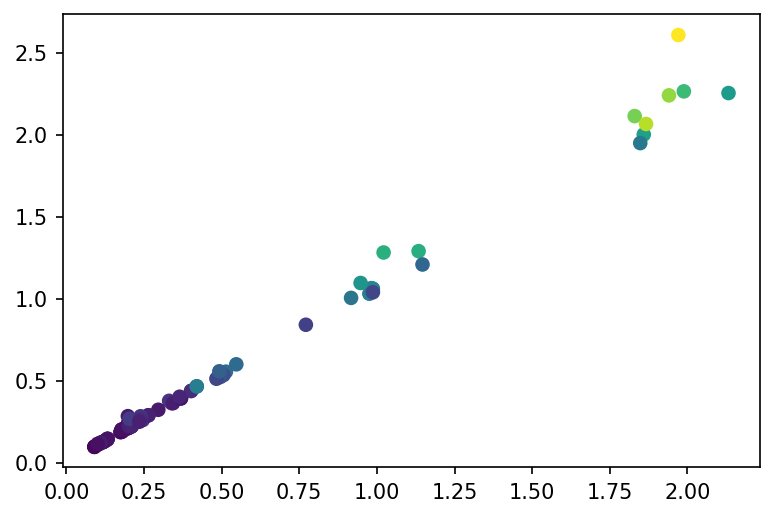

In [42]:
# is there really a difference between BT/DIC vs BT/HCO3
plt.scatter(dat.csys_mid.BT/dat.csys_mid.DIC, dat.csys_mid.BT/dat.csys_mid.HCO3, c=nom(dat[('Measured', 'B/Caf')]))

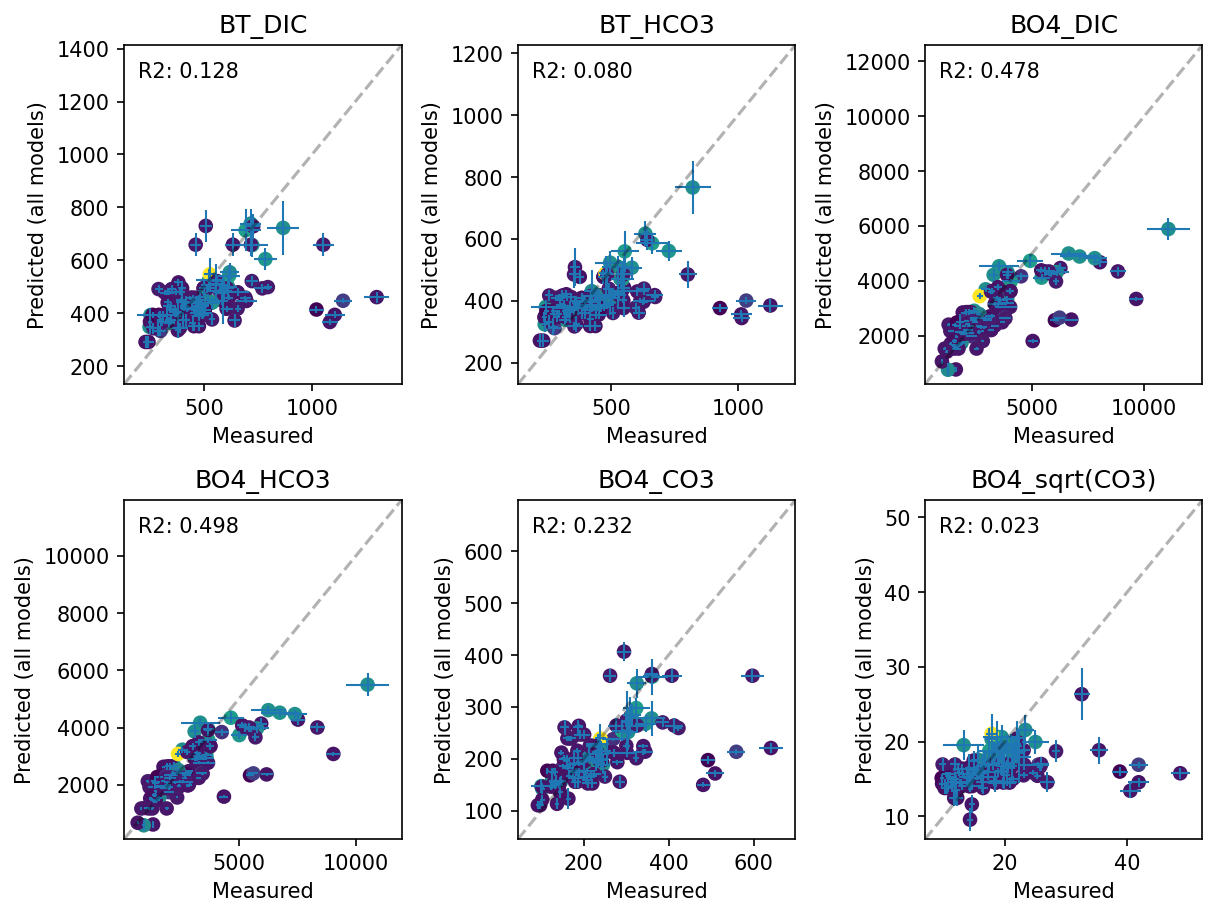

In [43]:
fig, axs = plt.subplots(2, 3, figsize=[8, 6], constrained_layout=True)

for k, ax in zip(brutes.keys(), axs.flat):
    b = brutes[k]
    b.plot_obs_vs_pred(ax=ax, c=dat[('Measured', '[B]sw')])
    ax.set_title(k)
    ax.set_aspect('auto')
    lim = min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax.plot(lim,lim,ls='dashed',color=(0,0,0,0.3))
    r2 = bf.stats.calc_R2(b.y_orig.ravel(), b.pred_means)
    ax.text(0.05, 0.95, f'R2: {r2:.3f}', va='top', ha='left', transform=ax.transAxes)

In [129]:
# Convert KB to B/Ca for all models

pred_kb2bca = {}

for b in ['BT', 'BO4']:
    for c in ['DIC', 'HCO3', 'CO3']:
        if b == 'BT' and c == 'CO3':
            continue
        ratio = f'{b}_{c}'
        print(ratio)
        kb_denom = (dat.loc[:, ('csys_mid', b)] / dat.loc[:, ('csys_mid', c)]).values
        pred_kb2bca[ratio] = brutes[ratio].pred_all * kb_denom

ratio = 'BO4_sqrt(CO3)'
print(ratio)
kb_denom = (dat.loc[:, ('csys_mid', 'BO4')] / dat.loc[:, ('csys_mid', 'CO3')]**0.5).values
pred_kb2bca[ratio] = brutes[ratio].pred_all * kb_denom

BT_DIC
BT_HCO3
BO4_DIC
BO4_HCO3
BO4_CO3
BO4_sqrt(CO3)


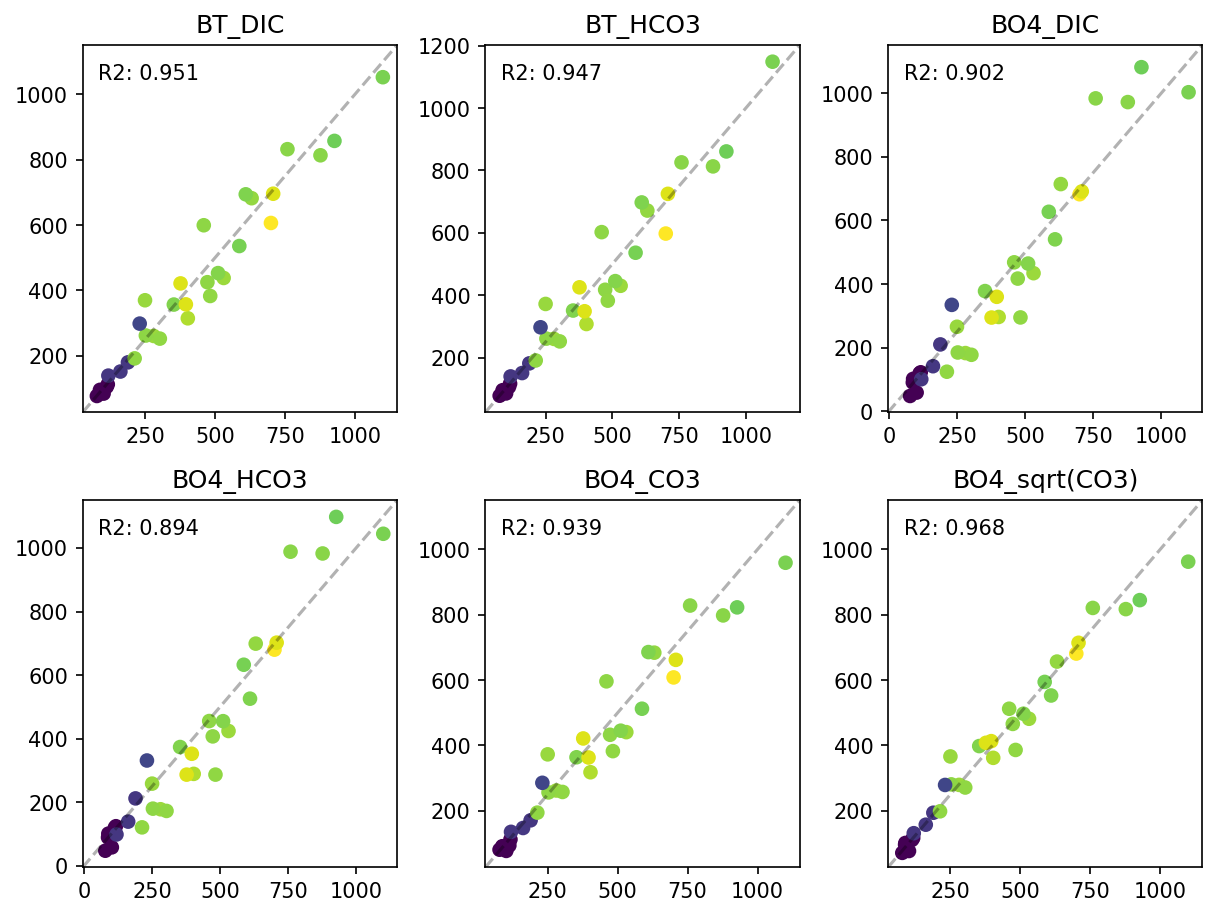

In [130]:
fig, axs = plt.subplots(2, 3, figsize=[8, 6], constrained_layout=True)

for k, ax in zip(brutes.keys(), axs.flat):
    x = nom(dat.loc[:, ('Measured', 'B/Caf')])
    x_err = err(dat.loc[:, ('Measured', 'B/Caf')])
    y = pred_kb2bca[k].mean(0)
    y_err = pred_kb2bca[k].std(0)
    
    ax.scatter(x,y, c=dat.csys_mid.BT)
    
    ax.set_title(k)
    ax.set_aspect('auto')
    lim = min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax.plot(lim,lim,ls='dashed',color=(0,0,0,0.3))
    r2 = bf.stats.calc_R2(x, y)
    ax.text(0.05, 0.95, f'R2: {r2:.3f}', va='top', ha='left', transform=ax.transAxes)

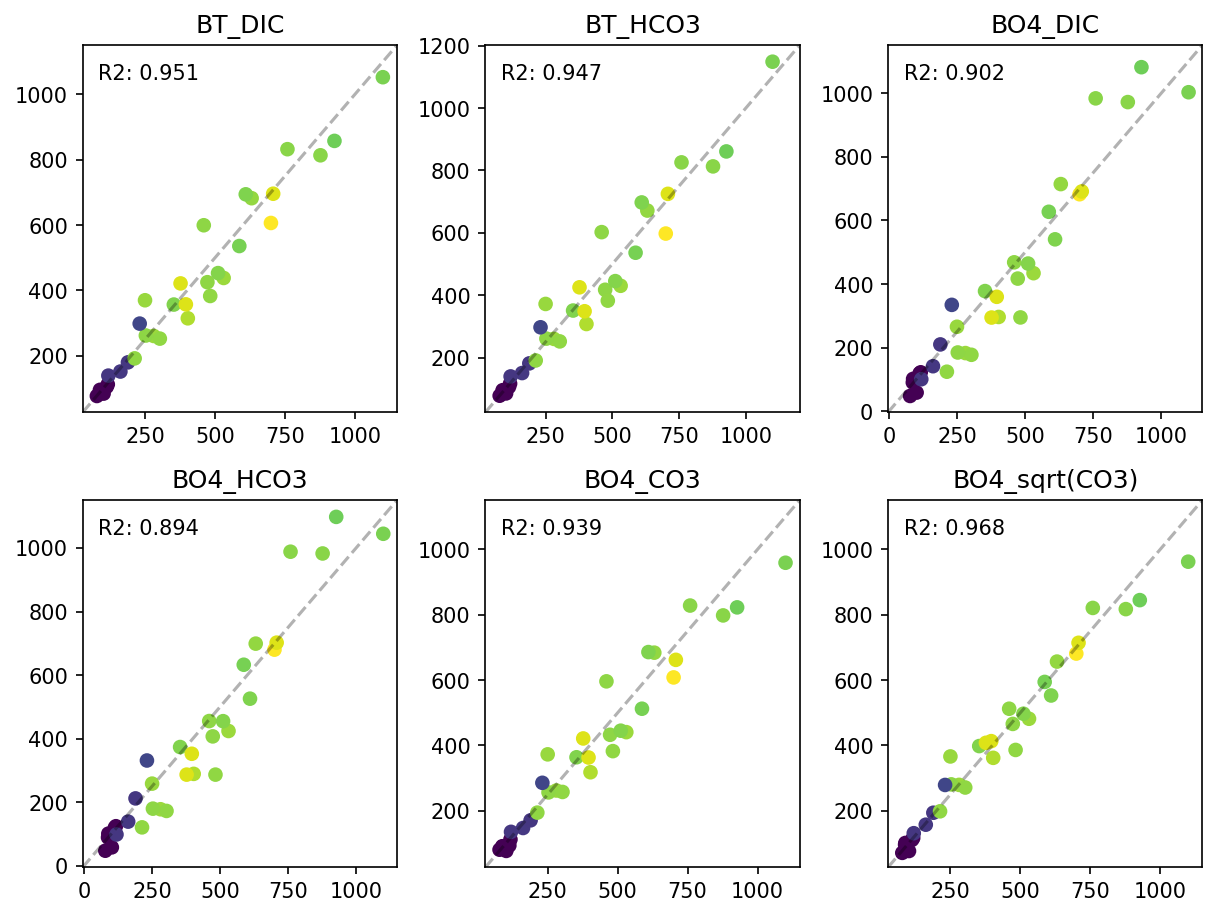

In [131]:
fig, axs = plt.subplots(2, 3, figsize=[8, 6], constrained_layout=True)

for k, ax in zip(brutes.keys(), axs.flat):
    x = nom(dat.loc[:, ('Measured', 'B/Caf')])
    x_err = err(dat.loc[:, ('Measured', 'B/Caf')])
    y = pred_kb2bca[k].mean(0)
    y_err = pred_kb2bca[k].std(0)
    
    ax.scatter(x,y, c=dat.csys_mid.BT)
    
    ax.set_title(k)
    ax.set_aspect('auto')
    lim = min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax.plot(lim,lim,ls='dashed',color=(0,0,0,0.3))
    r2 = bf.stats.calc_R2(x, y)
    ax.text(0.05, 0.95, f'R2: {r2:.3f}', va='top', ha='left', transform=ax.transAxes)

## Model Taylor Diagrams

In [132]:
markers = {
    "BT_DIC": "o",
    "BT_HCO3": "s",
    "BO4_DIC": "<",
    "BO4_HCO3": ">",
    "BO4_CO3": "v",
}

labels = {
    "BT_DIC": "$B_T / DIC$",
    "BT_HCO3": "$B_T / HCO_3^-$",
    "BO4_DIC": "$B(OH)_4^- / DIC$",
    "BO4_HCO3": "$B(OH)_4^- / HCO_3^-$",
    "BO4_CO3": "$B(OH)_4^- / CO_3^{2-}$",
}

In [61]:
from b_funks.taylor_diag import Taylor_diag, make_Taylor_axis
from matplotlib.colors import Normalize

In [62]:
previous_models = fit_data_with_previous_models(dat)

NameError: name 'fit_data_with_previous_models' is not defined

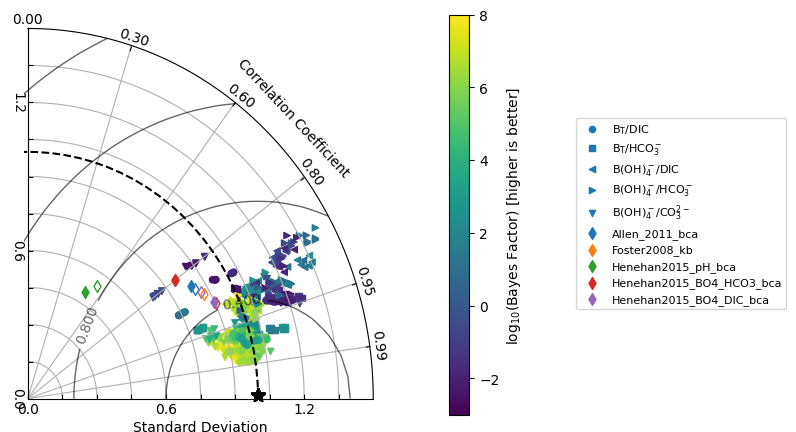

In [44]:
fig, ax = make_Taylor_axis(1.5, figsize=[10, 5])
# plot all brute models
vmin=-3
vmax=8
for k,v in pred_kb2bca.items():
    Taylor_diag(np.vstack([nom(dat.Measured['B/Caf'].values), v]), ax=ax, st_dev_max=1.5, marker=markers[k], s=20, label=labels[k], c=np.log10(brutes[k].modelfits.metrics.BF0), vmin=vmin, vmax=vmax)

# draw colorbar
cax = fig.add_axes([.55, .1, .02, .8])
fig.colorbar(plt.cm.ScalarMappable(Normalize(vmin=vmin, vmax=vmax)), cax=cax, label='$log_{10}$(Bayes Factor) [higher is better]')

# plot other bros

for k, v in previous_models['preds_all_data'].items():
    p = Taylor_diag(np.vstack([previous_models['ydata_all'][k], v]), ax=ax, label=k, marker='d', zorder=5)
    Taylor_diag(np.vstack([previous_models['ydata_training_conditions'][k], previous_models['preds_training_conditions'][k]]), ax=ax, facecolor=(0,0,0,0), lw=1, marker='d', edgecolor=p.get_facecolor(), zorder=4)

# draw legend
ax.legend(fontsize=8, bbox_to_anchor=[1.55, .1, .4, .8], loc='center left')


Fig 4 the papier?!

In [37]:
# fig, ax = make_Taylor_axis(2.5)

# var = 'DIC'

# for k,v in pred_kb2bca.items():
#     b = brutes[k]
#     var_ind = np.concatenate([[0], np.array(b.varnames) == var]).astype(bool)
#     var_present = ~b.modelfits.coefs.isnull().values[:, var_ind].flatten()  
    
#     # plot as present if in denominator
#     if var in k:
#         var_present = np.ones(b.modelfits.shape[0])
    
#     Taylor_diag(np.vstack([nom(dat.Measured['B/Caf'].values), v]), ax=ax, marker='o', s=20, label=k, c=var_present, vmin=0, vmax=1)

# fig.set_size_inches(5, 5)
# # ax.legend()

In [38]:
b.varnames

['[Ca]sw', '[Mg]sw', 'BO4', 'BT', 'CO3', 'pHtot', 'DIC']

In [39]:
mdict = {
    "BT_DIC": 'o',
    "BT_HCO3": 's',
    "BO4_DIC": 'd',
    "BO4_HCO3": 'v',
    "BO4_CO3": '^',
}

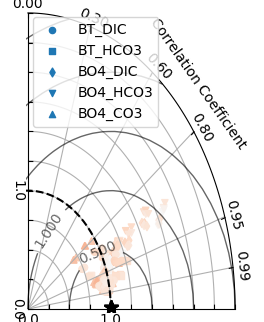

In [42]:
fig, ax = make_Taylor_axis(2.5)

var = '[Mg]sw'

vmin = -1
vmax = 1

for k,v in pred_kb2bca.items():
    b = brutes[k]
    var_ind = np.concatenate([[0], np.array(b.varnames) == var]).astype(bool)
    var_size = b.modelfits.coefs.values[:, var_ind].flatten()
    
    Taylor_diag(np.vstack([nom(dat.Measured['B/Caf'].values), v]), ax=ax, marker=mdict[k], s=20, label=k, c=var_size, vmin=vmin, vmax=vmax, cmap=plt.cm.RdBu_r) # , lw=0.5, edgecolor=(.6,.6,.6))
    
# fig.set_size_inches(5, 5)
ax.legend()

Notes: the diagonal points are an artefact... not sure why they're there. Points with nan in the colour variable plot along a 45 degree line!? Only visible when edge-color specified.

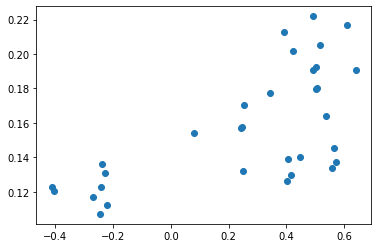

In [43]:
k = 'BT_DIC'
b = brutes[k]

xvar = 'pHtot'
yvar = '[Mg]sw'

xvar_ind = np.concatenate([[0], np.array(b.varnames) == xvar]).astype(bool)
xvar_size = b.modelfits.coefs.values[:, xvar_ind].flatten()

yvar_ind = np.concatenate([[0], np.array(b.varnames) == yvar]).astype(bool)
yvar_size = b.modelfits.coefs.values[:, yvar_ind].flatten()

plt.scatter(xvar_size, yvar_size)

(array([4., 4., 0., 0., 0., 0., 0., 1., 4., 3.]),
 array([-0.67453299, -0.57022806, -0.46592312, -0.36161819, -0.25731325,
        -0.15300832, -0.04870338,  0.05560155,  0.15990648,  0.26421142,
         0.36851635]),
 <BarContainer object of 10 artists>)

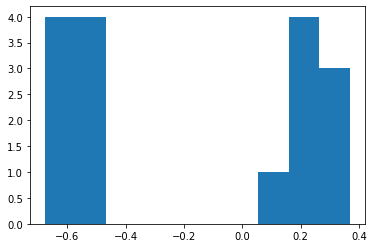

In [149]:
plt.hist(xvar_size)

## 'Best' Model

$$
\frac{B/Ca_{foram}}{[B] / [CO_3^{2-}]} = a [B(OH)_4^-] + b [B] + c [CO_3^{2-}]
$$

### Can this fit others' data (with an offset)?

In [48]:
mdict = {
    'This Study': 'o', 
    'Haynes et al. (2017)': 's', 
    'Allen et al. (2011)': 'd',
#     'Howes et al. (2017)': '*'
}

# variables used in fitting
target_vars = [('csys_mid', 'BO4'), ('csys_mid', 'BT'), ('csys_mid', 'CO3')]

# Kate's datas
ky = (kdat[('Measured', 'B/Caf')] / (kdat[('csys_mid', 'BT')] / kdat[('csys_mid', 'CO3')])).values.reshape(-1,1)
kX = kdat.loc[:, target_vars].values

# calculate scalers based on Kate's data
X_scaler = StandardScaler().fit(kX)
Y_scaler = StandardScaler().fit(ky)

# subset of other peoples' datas
tdat = odat.loc[odat.loc[:, ('Measured', 'who')].isin(mdict)]
tdat = tdat.loc[tdat.csys_mid.pHtot < 8.5]  # remove flyer in Kat's data

y = (tdat[('Measured', 'B/Caf')] / (tdat[('csys_mid', 'BT')] / tdat[('csys_mid', 'CO3')])).values.reshape(-1,1)
X = tdat.loc[:, target_vars].values

# transform others' datas
Xt = X_scaler.transform(X)
yt = Y_scaler.transform(y)

# Fit linear regression
model = LinearRegression(fit_intercept=False)

fit = model.fit(Xt, yt)
yp = fit.predict(Xt)

ypt = Y_scaler.inverse_transform(yp)

# compare to prediction using our best fit params
our_params = df.loc[0, 'coefs'].values[1:].astype(np.float)
our_params = our_params[~np.isnan(our_params)]

kyp = Xt.dot(our_params)
kypt = Y_scaler.inverse_transform(kyp)

fig, ax = plt.subplots()
ax.scatter(y, ypt, label="Best fit to others' data")
ax.scatter(y, kypt, label="Parameters from our best fit")

lim = ax.get_xlim()
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.plot(lim, lim, ls='dashed', c=(0,0,0,0.5))

ax.legend()

ValueError: shapes (74,3) and (4,) not aligned: 3 (dim 1) != 4 (dim 0)

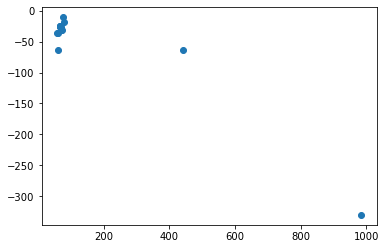

In [46]:
ypbca = ypt.flat * (tdat[('csys_mid', 'BT')] / tdat[('csys_mid', 'CO3')])
kypbca = kypt.flat * (tdat[('csys_mid', 'BT')] / tdat[('csys_mid', 'CO3')])


plt.scatter(tdat[('Measured', 'B/Caf')], ypbca - kypbca)
# plt.scatter(tdat[('Measured', 'B/Caf')], kypbca)

In [23]:
def c_offset(X, c):
    BCa, BT, CO3 = X 
    # Apply offset to others' B/Ca data
    oBCa = BCa + c
    # Caclulate partitioning
    return Y_scaler.transform((oBCa / (BT / CO3)).reshape(-1, 1))[:,0]

def m_offset(X, m):
    BCa, BT, CO3 = X 
    # Apply offset to others' B/Ca data
    oBCa = BCa * m
    # Caclulate partitioning
    return Y_scaler.transform((oBCa / (BT / CO3)).reshape(-1, 1))[:,0]

def cm_offset(X, c, m):
    BCa, BT, CO3 = X 
    # Apply offset to others' B/Ca data
    oBCa = c + BCa * m
    # Caclulate partitioning
    return Y_scaler.transform((oBCa / (BT / CO3)).reshape(-1, 1))[:,0]

In [24]:
Xu = tdat[('Measured', 'B/Caf')].values, tdat[('csys_mid', 'BT')].values, tdat[('csys_mid', 'CO3')].values

# constant offset
pc, covc = opt.curve_fit(c_offset, Xu, kyp.flat)
ypc = Y_scaler.inverse_transform(c_offset(Xu, *pc))

# multiplicative offset
pm, covm = opt.curve_fit(m_offset, Xu, kyp.flat)
ypm = Y_scaler.inverse_transform(m_offset(Xu, *pm))

# both offsets
pcm, covcm = opt.curve_fit(cm_offset, Xu, kyp.flat)
ypcm = Y_scaler.inverse_transform(cm_offset(Xu, *pcm))

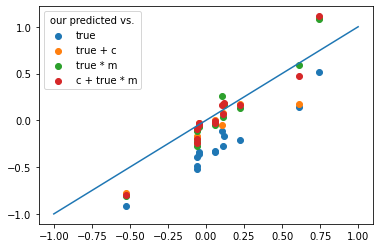

In [25]:
fig, ax = plt.subplots(1, 1)
ax.scatter(kyp, yt, label='true')
ax.scatter(kyp, c_offset(Xu, pc),  label='true + c')
ax.scatter(kyp, m_offset(Xu, pm), label='true * m')
ax.scatter(kyp, cm_offset(Xu, *pcm),  label='c + true * m')

lim = [-1., 1.]
ax.plot(lim, lim)
ax.legend(title='our predicted vs.')

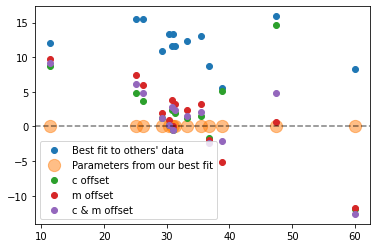

In [161]:
fig, ax = plt.subplots()
ax.scatter(y, kypt - ypt.flat, label="Best fit to others' data")
ax.scatter(y.flat, kypt - kypt, label="Parameters from our best fit", s=150, alpha=0.5)

ax.scatter(y, kypt - ypc, label="c offset")
ax.scatter(y, kypt - ypm, label="m offset")
ax.scatter(y, kypt - ypcm, label="c & m offset")

# lim = ax.get_xlim()
# ax.set_xlim(lim)
# ax.set_ylim(lim)
# ax.plot(lim, lim, ls='dashed', c=(0,0,0,0.5))
ax.axhline(0, ls='dashed', c=(0,0,0,0.5))

ax.legend()

In [205]:
# this isn't quite right - should be applying the offset to the B/Ca data then recalculating partitioning in fitting.

def c_offset(X, c):
    return c + X.dot(our_params)

def m_offset(X, m):
    return p[0] * X.dot(our_params)

def cm_offset(X, c, m):
    return c + m * X.dot(our_params)

In [206]:
# constant offset
pc, covc = opt.curve_fit(c_offset, Xt, yt.flat)
ypc = Y_scaler.inverse_transform(c_offset(Xt, *pc))
# multiplicative offset
pm, covm = opt.curve_fit(m_offset, Xt, yt.flat)
ypm = Y_scaler.inverse_transform(m_offset(Xt, *pm))
# both
pcm, covcm = opt.curve_fit(cm_offset, Xt, yt.flat)
ypcm = Y_scaler.inverse_transform(cm_offset(Xt, *pcm))


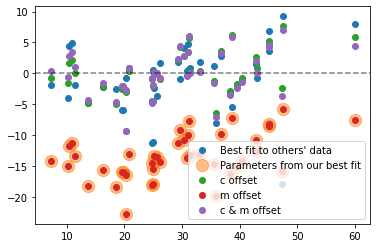

In [207]:
fig, ax = plt.subplots()
ax.scatter(y, y - ypt, label="Best fit to others' data")
ax.scatter(y.flat, y.flat - kypt, label="Parameters from our best fit", s=150, alpha=0.5)

ax.scatter(y, y.flat - ypc, label="c offset")
ax.scatter(y, y.flat - ypm, label="m offset")
ax.scatter(y, y.flat - ypcm, label="c & m offset")

# lim = ax.get_xlim()
# ax.set_xlim(lim)
# ax.set_ylim(lim)
# ax.plot(lim, lim, ls='dashed', c=(0,0,0,0.5))
ax.axhline(0, ls='dashed', c=(0,0,0,0.5))

ax.legend()

## K8 Plot

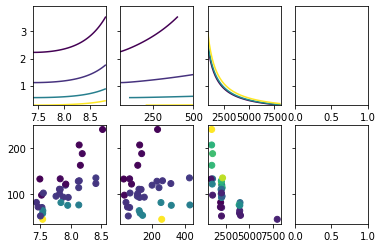

In [77]:
fig, axs = plt.subplots(2, 4, sharex=False, sharey='row')

pH = np.linspace(7.4, 8.8)
DIC = np.linspace(900, 8100)
B = 420 * 5

xpH, xDIC = np.meshgrid(pH, DIC)

sw = cb.CBsys(pHtot=xpH, DIC=xDIC, BT=B, dBT=39.6)

ax = axs[0,0]
cvar = (sw.BT / sw.HCO3)
ax.contour(xpH, cvar, xDIC, [1000, 2000, 4000, 8000])

ax = axs[1,0]
ydat = dat.loc[:, ('Measured', 'B/Caf_corr')]
# ydat = dat.loc[:, ('Measured', 'KB')]
ax.scatter(dat.loc[:, ('csys_mid', 'pHtot')], ydat, c=dat.loc[:, ('csys_mid', 'DIC')])


ax = axs[0,1]
ax.contour(sw.CO3, cvar, xDIC, [1000, 2000, 4000, 8000])
ax.set_xlim(50, 500)

ax = axs[1,1]
ax.scatter(dat.loc[:, ('csys_mid', 'CO3')], ydat, c=dat.loc[:, ('csys_mid', 'DIC')])

ax = axs[0, 2]
ax.contour(xDIC, cvar, xpH, [7.6, 8, 8.4])

ax = axs[1,2]
ax.scatter(dat.loc[:, ('csys_mid', 'DIC')], ydat, c=dat.loc[:, ('csys_mid', 'pHtot')])


## Shambling Ground:

In [ ]:
# b.varnames

$$
B/Ca = a [CO3] + b \frac{B}{HCO3}
$$

In [ ]:
nmod = 1
# b = brutes[df.loc[nmod, 'r'][0]]
b = brutes

b.predict()
b.plot_obs_vs_pred()
plt.scatter(b.y_orig, b.pred_all[0, :], color='C1')

xlim = plt.gca().get_xlim()
plt.xlim(xlim)
plt.ylim(xlim)
plt.plot(xlim, xlim)

In [ ]:
b.modelfits

In [ ]:
dat.columns.shape

In [ ]:
resid = b.pred_all[0] - b.y_orig.T

nvar = b.X_orig.shape[1]

fig, axs = plt.subplots(nvar//2, 2, figsize=[nvar * 2.5, 6])

for i, ax in enumerate(axs.flat):
    ax.scatter(b.X_orig[:, i], resid, c=dat.loc[:, cvar])
    ax.set_xlabel(b.varnames[i])
    
fig.tight_layout()

In [ ]:
resid = b.pred_all[0] - b.y_orig.T

nvar = b.X_orig.shape[1]

fig, axs = plt.subplots(8, 8, figsize=[16,16])

for i, ax in enumerate(axs.flat):
    if i >= dat.shape[1]:
        continue
    if dat.dtypes[i] == 'O':
        continue
    ax.scatter(dat.loc[:, dat.columns[i]], resid)
    ax.set_xlabel(', '.join(dat.columns[i]))
    
fig.tight_layout()

In [ ]:
plt.scatter(dat.loc[:, ('csys_mid', 'CO3')], dat.loc[:, ('Measured', '[Ca]sw')], c=dat.loc[:, ('csys_mid', 'Omega')])
plt.colorbar()

## Pull this model out, fit it and look at the residuals!

In [ ]:
dat.Measured.columns

In [ ]:
plt.rcParams['figure.dpi'] = 150

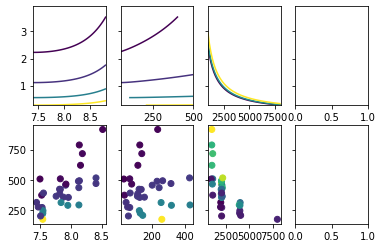

In [65]:
import cbsyst as cb

fig, axs = plt.subplots(2, 4, sharex=False, sharey='row')

pH = np.linspace(7.4, 8.8)
DIC = np.linspace(900, 8100)
B = 420 * 5

xpH, xDIC = np.meshgrid(pH, DIC)

sw = cb.CBsys(pHtot=xpH, DIC=xDIC, BT=B, dBT=39.6)

ax = axs[0,0]
cvar = (sw.BT / sw.HCO3)
ax.contour(xpH, cvar, xDIC, [1000, 2000, 4000, 8000])

ax = axs[1,0]
ydat = dat.loc[:, ('Measured', 'B/Caf')] / (dat.loc[:, ('Measured', '[B]sw')] / dat.loc[:, ('Measured', '[B]sw')].mean() )#/ (dat.loc[:, ('Measured', 'B umol/kg')] / dat.loc[:, ('csys_mid', 'HCO3')])
ax.scatter(dat.loc[:, ('csys_mid', 'pHtot')], ydat, c=dat.loc[:, ('csys_mid', 'DIC')])


ax = axs[0,1]
ax.contour(sw.CO3, cvar, xDIC, [1000, 2000, 4000, 8000])
ax.set_xlim(50, 500)

ax = axs[1,1]
ax.scatter(dat.loc[:, ('csys_mid', 'CO3')], ydat, c=dat.loc[:, ('csys_mid', 'DIC')])

ax = axs[0, 2]
ax.contour(xDIC, cvar, xpH, [7.6, 8, 8.4])

ax = axs[1,2]
ax.scatter(dat.loc[:, ('csys_mid', 'DIC')], ydat, c=dat.loc[:, ('csys_mid', 'pHtot')])


In [66]:
# cvar = ('Measured', '[Ca]sw')
# cvar = ('Measured', '[Mg]sw')
# cvar = ('csys_mid', 'Omega')
# cvar = ('csys_mid', 'CO3')
cvar = ('csys_mid', 'DIC')
# cvar = ('Measured', 'B umol/kg')

# bca_norm = dat.loc[:, ('Measured', 'B/Caf')] #/ (dat.loc[:, ('Measured', 'B umol/kg')] / dat.loc[:, ('Measured', 'B umol/kg')].mean())
y = dat.loc[:, ('Measured', 'KB')] #/ (dat.loc[:, ('Measured', 'B umol/kg')] / dat.loc[:, ('Measured', 'B umol/kg')].mean())

x = dat.loc[:, ('Measured', 'B umol/kg')] / dat.loc[:, ('csys_mid', 'DIC')]
# x = dat.loc[:, ('csys_mid', 'DIC')]

plt.scatter(x, y, c=dat.loc[:, cvar])

KeyError: ('Measured', 'B umol/kg')

In [ ]:
sdat.csys_mid

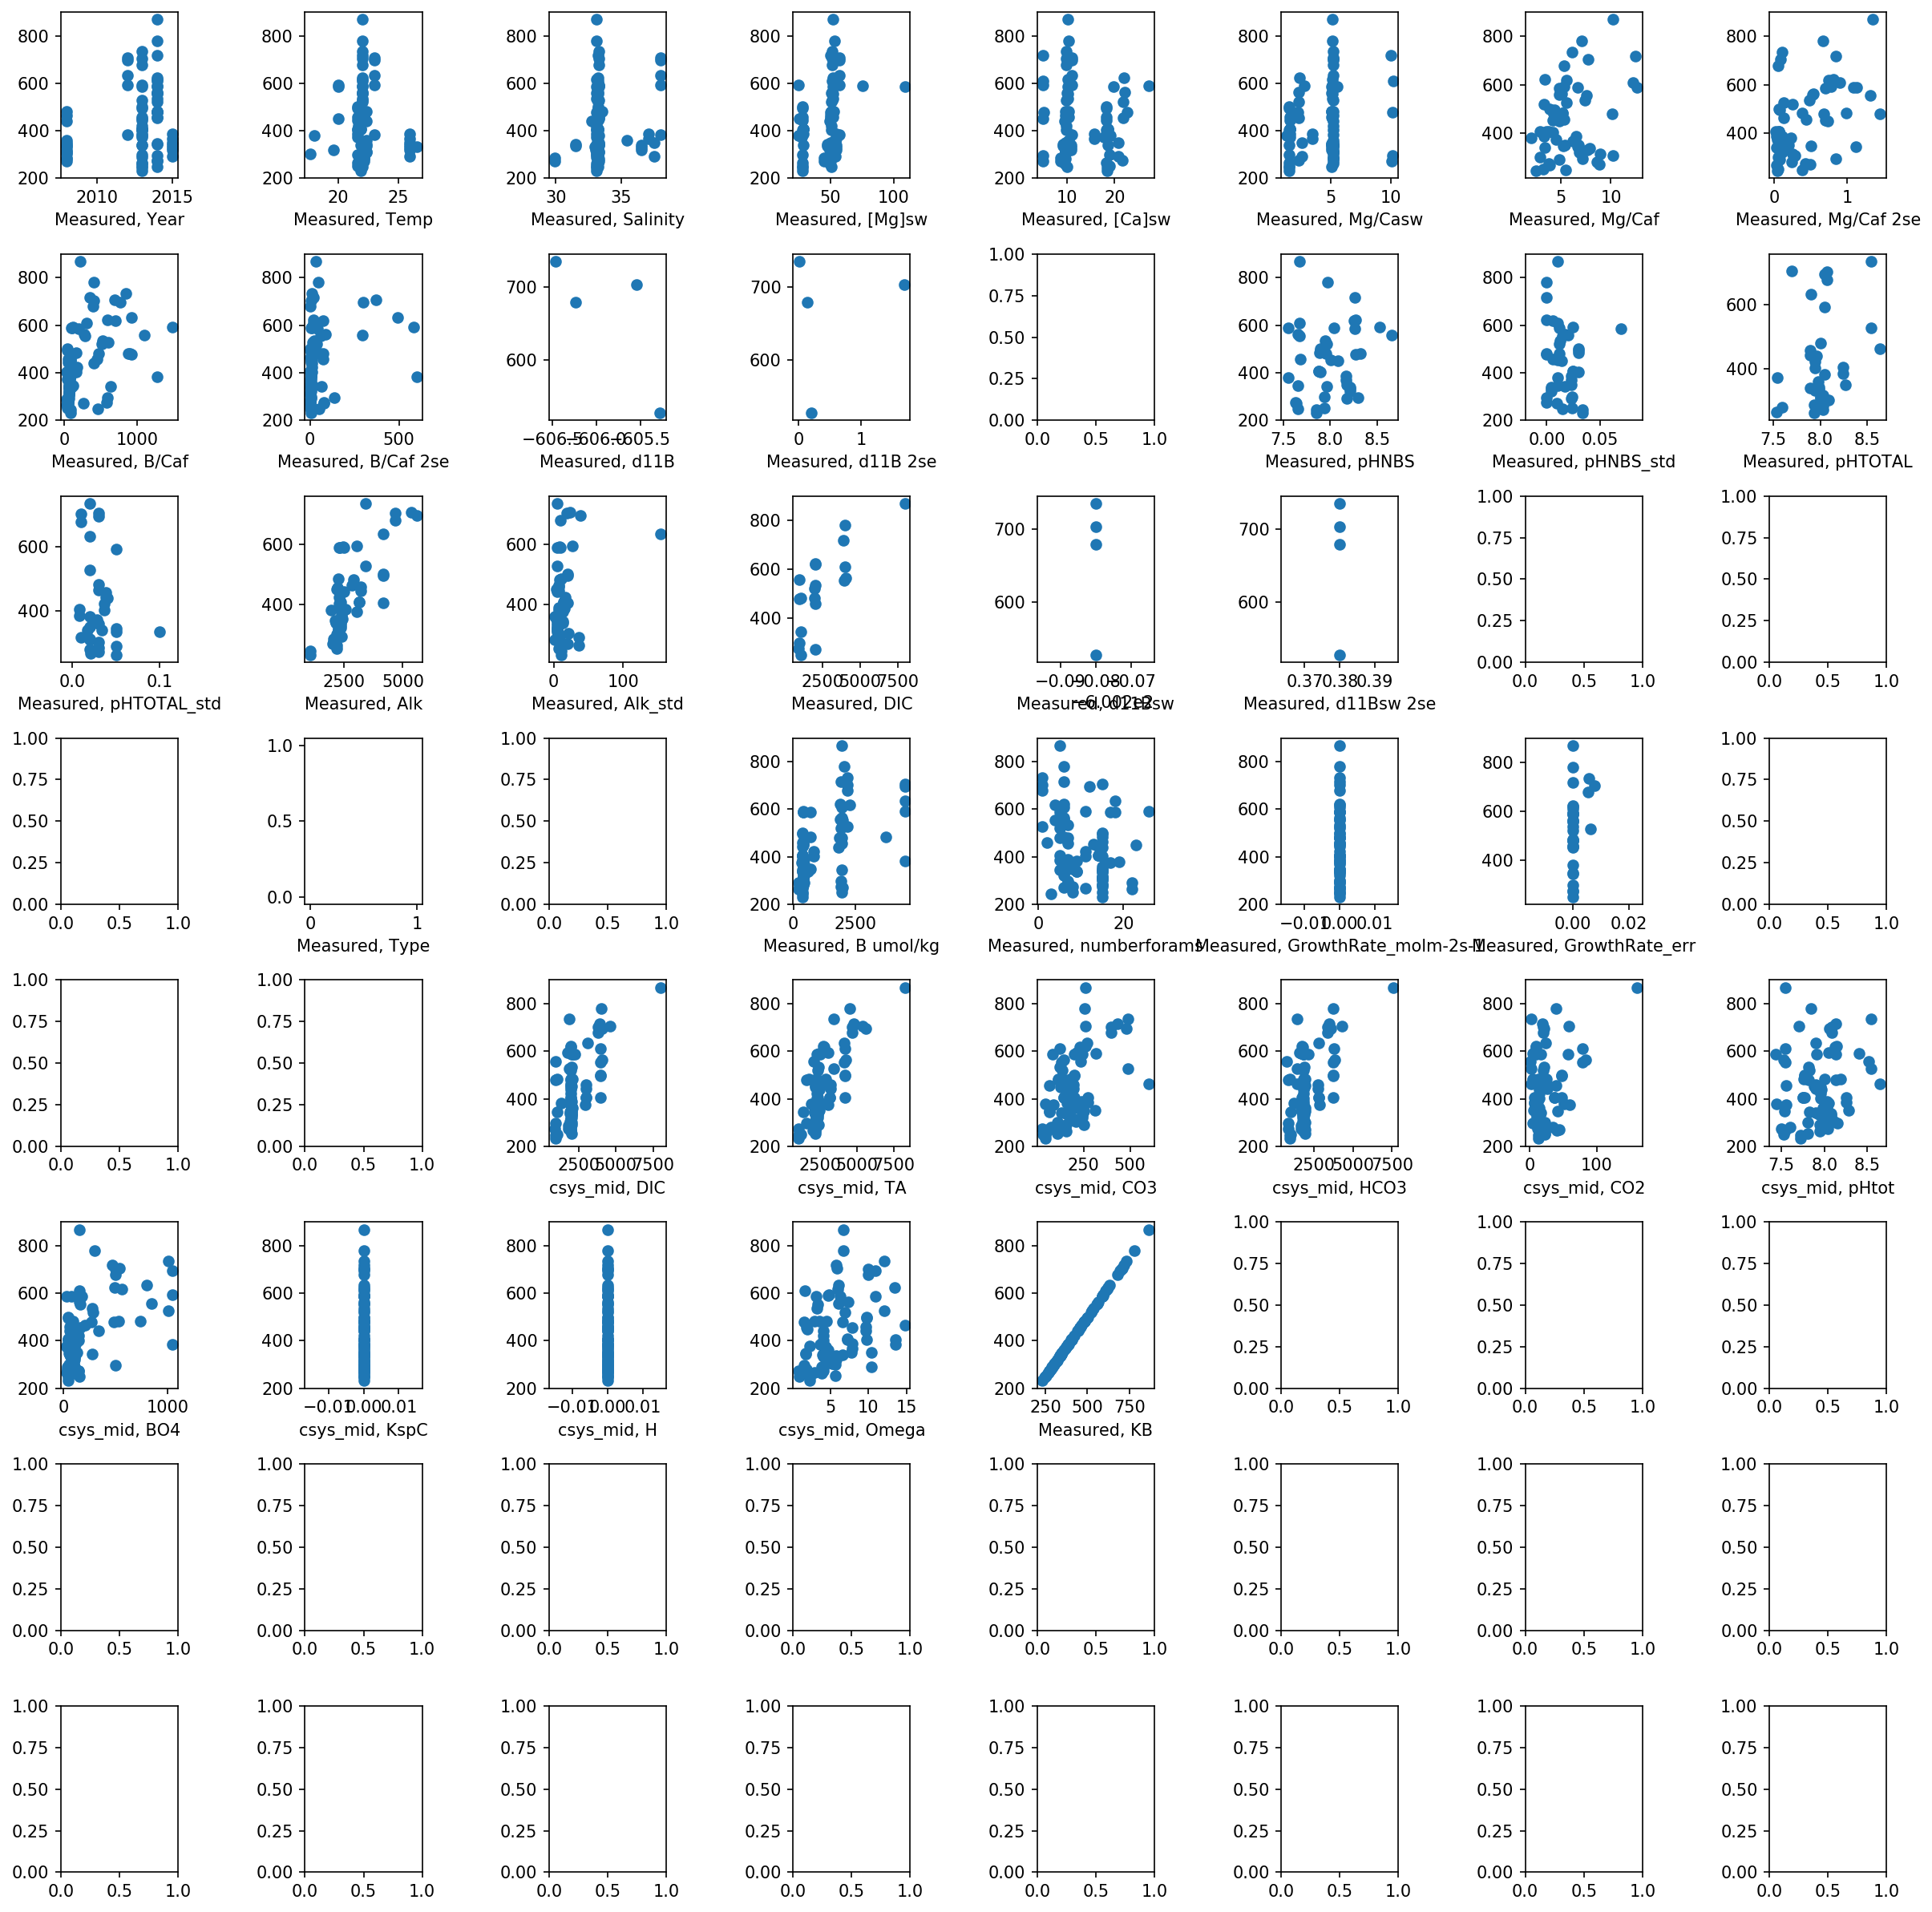

In [222]:
resid = dat.loc[:, ('Measured', 'KB')]

sdat = dat.loc[:, ['Measured', 'csys_mid']]
nvar = b.X_orig.shape[1]

fig, axs = plt.subplots(8, 8, figsize=[16,16])

i = 0
for ax in axs.flat:
    if i >= sdat.shape[1]:
        continue
    if sdat.dtypes[i] == 'O':
        i += 1
        continue
    ax.scatter(sdat.loc[:, sdat.columns[i]], resid)
    ax.set_xlabel(', '.join(sdat.columns[i]))
    i += 1

fig.tight_layout()